# Foundation Project - Oil Production Forecasting

## *Group-01*
1. Ritik Ranjan - 12410083
2. Medha Adhikari - 12410093
3. Battula Pragati - 12410084
4. Vishal Sharma - 12410005
5. Challa Dhanunjaya Reddy - 12320006

# Part 1: Data Extraction, Cleaning, Visualization, and Storage for US Oil Production

## 1. Library Imports

To begin, we imported the necessary Python libraries for data scraping, manipulation, time series analysis, and visualization:

- `pandas`, `numpy` — Data handling and manipulation
- `requests`, `BeautifulSoup` — Web scraping
- `matplotlib`, `seaborn` — Visualization
- `datetime`, `warnings` — Utilities
- `statsmodels` — Time series decomposition and autocorrelation analysis

## 2. Data Scraping

We scraped historical monthly crude oil production data from the **U.S. Energy Information Administration (EIA)** website:

- Sent an HTTP GET request to the EIA URL.
- Parsed the HTML using `BeautifulSoup`.
- Extracted the production data table.

## 3. Data Cleaning and Transformation

### Steps Taken:
- Parsed HTML to extract rows from the production table.
- Converted rows to a `pandas.DataFrame`.
- Dynamically generated column names (Year + Month).
- Melted the wide-format DataFrame into long format.
- Created a proper `Date` column by combining `Year` and `Month`.
- Removed commas from production figures and converted them to integers.
- Filtered data between **January 2010** and the **latest available valid date**.
- Ensured all production values were non-zero and valid.

## 4. Exploratory Data Analysis (EDA)

We used several visualization techniques to understand production patterns:

### Line Plot:
- Visualized oil production over time from 2010 to the most recent month.

### Histogram:
- Showed the distribution of monthly production values.

### Boxplots:
- Compared production distributions by:
  - Year
  - Month

### Seasonal Plot:
- Displayed monthly production trends for each year to observe recurring patterns.

## 5. Time Series Decomposition

We decomposed the time series using both **additive** and **multiplicative** models:

- Extracted trend, seasonal, and residual components using `seasonal_decompose`.
- Set `period=12` for monthly seasonality.
- Visualized the decomposition results with proper layout and titles.

## 6. Stationarity and Partial Autocorrelation

- Applied **first-order differencing** to remove trend.
- Plotted the **Partial Autocorrelation Function (PACF)** to assess autocorrelation structure and lag relationships (up to 24 months).

## 7. Data Storage

We saved the cleaned and filtered dataset in two formats:

- **SQLite database** (`oil_production.db`):
  - Stored as a table named `'production_data'`
- **CSV file** (`oil_production.csv`):
  - For easy sharing or use with other tools.

## Summary

At the end of Part 1, we have:
- Successfully scraped, cleaned, and structured the EIA crude oil production data.
- Conducted thorough exploratory and seasonal analysis.
- Performed decomposition and autocorrelation checks.
- Saved the processed data locally for downstream modeling and forecasting.


In [338]:
pip install beautifulsoup4

In [339]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Print statement to confirm that libraries were imported successfully
print("All required libraries have been successfully imported.")

All required libraries have been successfully imported.


In [340]:
# URL of the webpage to scrape
url = "https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=MCRFPUS1&f=M"
print(f"Target URL: {url}")

# Send a GET request to the URL
response = requests.get(url)
print(f"HTTP GET request sent. Status code: {response.status_code}")

Target URL: https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=MCRFPUS1&f=M
HTTP GET request sent. Status code: 200


In [341]:
# Parse the HTML content of the page
soup = BeautifulSoup(response.content, "html.parser")
print("HTML content parsed successfully.")

# Find the table containing the data
table = soup.find("table", {"class": "FloatTitle"})

if table:
    print("Data table found in the HTML content.")
else:
    print(" Data table not found. Check if the class name has changed or if the page structure has been updated.")

# Extract the rows of the table
rows = table.find_all("tr")
print(f"Number of table rows extracted: {len(rows)}")

HTML content parsed successfully.
Data table found in the HTML content.
Number of table rows extracted: 128


In [342]:
rows

[<tr bgcolor="#993333"> <th class="G2">Year</th> <th class="G">Jan</th> <th class="G">Feb</th> <th class="G">Mar</th> <th class="G">Apr</th> <th class="G">May</th> <th class="G">Jun</th> <th class="G">Jul</th> <th class="G">Aug</th> <th class="G">Sep</th> <th class="G">Oct</th> <th class="G">Nov</th> <th class="G">Dec</th> </tr>,
 <tr> <td class="B4">  1920</td> <td class="B3">34,008</td> <td class="B3">33,193</td> <td class="B3">36,171</td> <td class="B3">34,945</td> <td class="B3">36,622</td> <td class="B3">36,663</td> <td class="B3">37,746</td> <td class="B3">38,906</td> <td class="B3">37,521</td> <td class="B3">39,584</td> <td class="B3">38,609</td> <td class="B3">38,961</td> </tr>,
 <tr> <td class="B4">  1921</td> <td class="B3">38,138</td> <td class="B3">35,524</td> <td class="B3">41,105</td> <td class="B3">40,233</td> <td class="B3">42,189</td> <td class="B3">40,548</td> <td class="B3">40,461</td> <td class="B3">41,109</td> <td class="B3">36,763</td> <td class="B3">35,832</td> <

In [343]:
# Initialize list to store data
data = []
print("Starting to process table rows...")

for i, row in enumerate(rows):
    cols = row.find_all("td")  # Extract all <td> elements

    # Skip spacer rows with a single cell and colspan attribute
    if len(cols) == 1 and cols[0].has_attr("colspan"):
        continue

    # Extract text and remove extra spaces
    cols = [col.text.strip() for col in cols]

    # Append non-empty rows to the data list
    if cols:
        data.append(cols)

print(f"Total non-empty data rows extracted: {len(data)}")

Starting to process table rows...
Total non-empty data rows extracted: 106


In [344]:
# Convert the data into a Pandas DataFrame
df = pd.DataFrame(data)
print("Raw data converted into a DataFrame.")
print("Initial preview of DataFrame:")
print(df.head())

# Generate column names dynamically (e.g., Year, January, ..., December)
columns = ['Year'] + list(pd.date_range('2024-01-01', periods=12, freq='M').strftime('%B'))
print(f"Generated column names: {columns}")

# Assign the new column names to the DataFrame
df.columns = columns
print("Column names assigned successfully.")

# Display the updated DataFrame
print("Updated DataFrame preview:")
print(df.head())

# Display unique years found in the dataset
unique_years = df['Year'].unique()
print(f"Unique years in the dataset: {unique_years}")

Raw data converted into a DataFrame.
Initial preview of DataFrame:
     0       1       2       3       4       5       6       7       8   \
0  1920  34,008  33,193  36,171  34,945  36,622  36,663  37,746  38,906   
1  1921  38,138  35,524  41,105  40,233  42,189  40,548  40,461  41,109   
2  1922  43,696  41,314  47,188  45,167  47,002  46,087  47,134  47,059   
3  1923  52,527  48,588  56,969  59,008  62,377  62,845  65,925  66,422   
4  1924  57,273  55,889  60,141  59,830  61,834  59,583  61,932  62,398   

       9       10      11      12  
0  37,521  39,584  38,609  38,961  
1  36,763  35,832  38,108  42,173  
2  45,805  48,410  48,027  50,642  
3  65,306  67,506  65,388  59,546  
4  60,376  60,469  56,782  57,433  
Generated column names: ['Year', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
Column names assigned successfully.
Updated DataFrame preview:
   Year January February   March   April     May

In [345]:
# Display the last few rows of the DataFrame
print("Preview of the last 5 rows in the DataFrame:")
print(df.tail())

# Display DataFrame information (column types, non-null counts, memory usage)
print("DataFrame info:")
df.info()

Preview of the last 5 rows in the DataFrame:
     Year  January February    March    April      May     June     July  \
101  2021  345,713  278,271  352,545  340,585  354,103  341,813  353,905   
102  2022  354,716  321,080  368,134  354,365  363,992  357,385  371,739   
103  2023  390,928  352,534  397,280  380,410  394,619  385,967  400,994   
104  2024  389,161  379,960  408,294  397,459  409,235  397,196  408,950   
105  2025  407,537                                                         

      August September  October November December  
101  350,736   328,715  360,746  356,024  364,322  
102  375,798   373,159  385,369  374,003  377,429  
103  404,469   395,300  407,615  398,433  412,547  
104  414,270   395,541  416,953  400,561  416,988  
105                                                
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     ----------

In [346]:
# Melting the DataFrame to long format for easier analysis
df = df.melt(id_vars=["Year"], var_name="Month", value_name="Production")
print("DataFrame melted to long format.")
print("Preview after melting:")
print(df.head())

# Creating a 'Date' column by combining 'Year' and 'Month'
df["Date"] = pd.to_datetime(df["Year"].astype(str) + " " + df["Month"], format="%Y %B")
print("Date column created successfully.")

# Sorting the DataFrame by date and resetting the index
df = df.sort_values("Date").reset_index(drop=True)
print("DataFrame sorted by Date and index reset.")
print("Preview after sorting:")
print(df.head())

# Displaying DataFrame information
print("DataFrame info after reshaping and date transformation:")
df.info()

DataFrame melted to long format.
Preview after melting:
   Year    Month Production
0  1920  January     34,008
1  1921  January     38,138
2  1922  January     43,696
3  1923  January     52,527
4  1924  January     57,273
Date column created successfully.
DataFrame sorted by Date and index reset.
Preview after sorting:
   Year     Month Production       Date
0  1920   January     34,008 1920-01-01
1  1920  February     33,193 1920-02-01
2  1920     March     36,171 1920-03-01
3  1920     April     34,945 1920-04-01
4  1920       May     36,622 1920-05-01
DataFrame info after reshaping and date transformation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Year        1272 non-null   object        
 1   Month       1272 non-null   object        
 2   Production  1272 non-null   object        
 3   Date        1272 non-null   da

In [347]:
# Remove commas, coerce non-numeric values to NaN, fill with 0, then convert to integers
df['Production'] = (
    pd.to_numeric(df['Production'].str.replace(',', ''), errors='coerce')
    .fillna(0)
    .astype(int)
)
print("Production column cleaned and converted to integer type.")

# Display updated DataFrame info
print("Updated DataFrame info after cleaning 'Production' column:")
df.info()

Production column cleaned and converted to integer type.
Updated DataFrame info after cleaning 'Production' column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Year        1272 non-null   object        
 1   Month       1272 non-null   object        
 2   Production  1272 non-null   int64         
 3   Date        1272 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 39.9+ KB


In [348]:
# Get the current date in 'YYYY-MM-DD' format
current_date = datetime.today().strftime('%Y-%m-%d')
print(f"Current date: {current_date}")

# Find the latest date where 'Production' is non-zero and before or equal to today
latest_valid_date = df[
    (df["Production"] > 0) & (df["Date"] <= current_date)
]["Date"].max()
print(f"Latest valid date with non-zero production: {latest_valid_date.date()}")

# Filter the DataFrame from January 2010 up to the latest valid date
df_filtered = df[
    (df["Date"] >= "2010-01-01") & (df["Date"] <= latest_valid_date)
].reset_index(drop=True)
print(f"Filtered data from 2010-01-01 to {latest_valid_date.date()}")
print(f"Total records after filtering: {len(df_filtered)}")

# Display descriptive statistics of the 'Production' column
print("Descriptive statistics of Production:")
print(df_filtered['Production'].describe())

Current date: 2025-04-20
Latest valid date with non-zero production: 2025-01-01
Filtered data from 2010-01-01 to 2025-01-01
Total records after filtering: 181
Descriptive statistics of Production:
count       181.000000
mean     296168.524862
std       77679.483428
min      151354.000000
25%      235142.000000
50%      291333.000000
75%      364322.000000
max      416988.000000
Name: Production, dtype: float64


Plotting figure initialized with size 10x6.
Production data plotted against Date.
Title and axis labels added.
X-axis labels rotated.


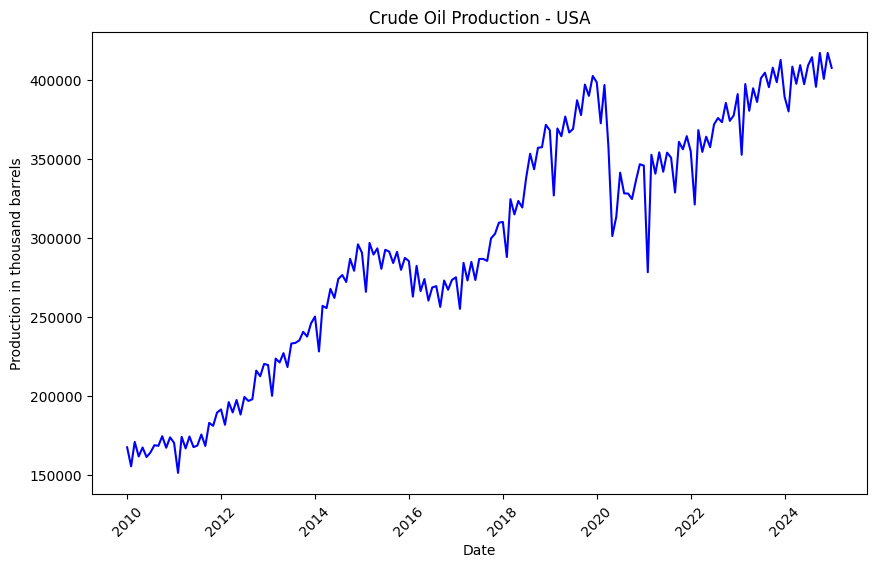

Plot displayed.


In [349]:
# Set up the figure size
plt.figure(figsize=(10, 6))
print("Plotting figure initialized with size 10x6.")

# Plot the 'Production' time series
plt.plot(df_filtered['Date'], df_filtered['Production'], linestyle='-', color='b')
print("Production data plotted against Date.")

# Add labels and title
plt.title('Crude Oil Production - USA')
plt.ylabel('Production in thousand barrels')
plt.xlabel('Date')
print("Title and axis labels added.")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
print("X-axis labels rotated.")

# Show the plot
plt.show()
print("Plot displayed.")

Initialized histogram figure with size 10x6.
Histogram and KDE of Production plotted.
Plot title and axis labels set.


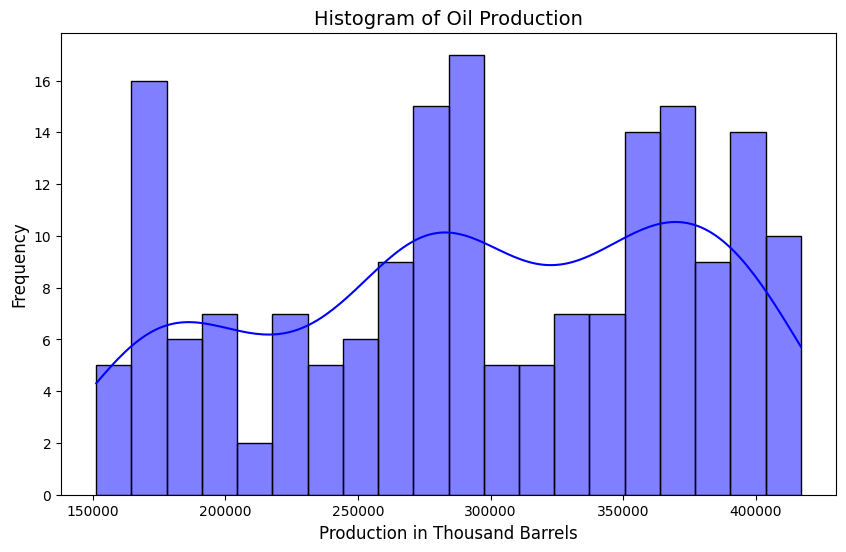

Histogram displayed.


In [350]:
# Plot histogram of the 'Production' column
plt.figure(figsize=(10, 6))
print("Initialized histogram figure with size 10x6.")

sns.histplot(df_filtered['Production'], bins=20, kde=True, color='blue')
print("Histogram and KDE of Production plotted.")

# Formatting the plot
plt.title('Histogram of Oil Production', fontsize=14)
plt.xlabel('Production in Thousand Barrels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
print("Plot title and axis labels set.")

# Show the plot
plt.show()
print("Histogram displayed.")

Initialized box plot figure with size 6x4.
Box plot of Production column generated.
Plot title and x-axis label set.


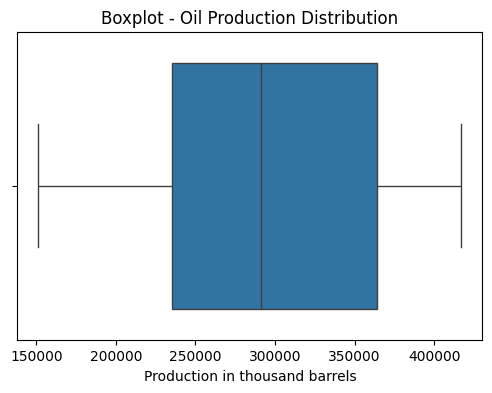

Box plot displayed.


In [351]:
# Plotting a box plot to visualize production distribution
plt.figure(figsize=(6, 4))
print("Initialized box plot figure with size 6x4.")

sns.boxplot(data=df_filtered, x='Production')
print("Box plot of Production column generated.")

# Formatting the plot
plt.xlabel('Production in thousand barrels')
plt.title('Boxplot - Oil Production Distribution')
print("Plot title and x-axis label set.")

# Display the plot
plt.show()
print("Box plot displayed.")

Initialized yearly boxplot figure with size 12x6.
Boxplot of yearly production generated.
Plot title, axis labels, and x-axis rotation set.


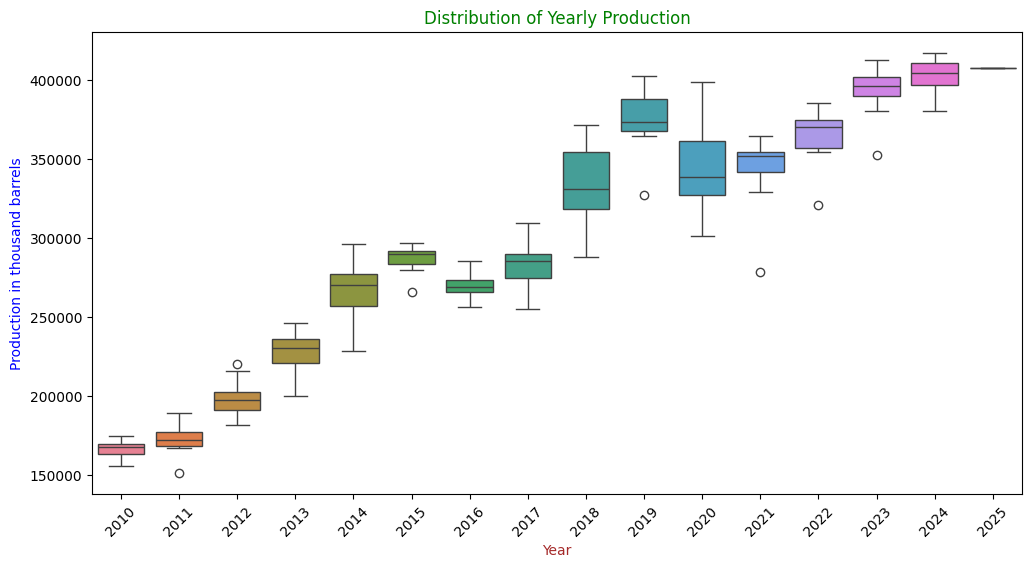

Yearly boxplot displayed.


In [352]:
# Plotting a boxplot of Production by Year
plt.figure(figsize=(12, 6))
print("Initialized yearly boxplot figure with size 12x6.")

sns.boxplot(x='Year', y='Production', data=df_filtered, palette='husl')
print("Boxplot of yearly production generated.")

# Formatting the plot
plt.title('Distribution of Yearly Production', color='green')
plt.xlabel('Year', color='brown')
plt.ylabel('Production in thousand barrels', color='blue')
plt.xticks(rotation=45)
print("Plot title, axis labels, and x-axis rotation set.")

# Display the plot
plt.show()
print("Yearly boxplot displayed.")

Initialized monthly boxplot figure with size 12x6.
Boxplot of monthly production generated.
Plot title, axis labels, and x-axis rotation set.


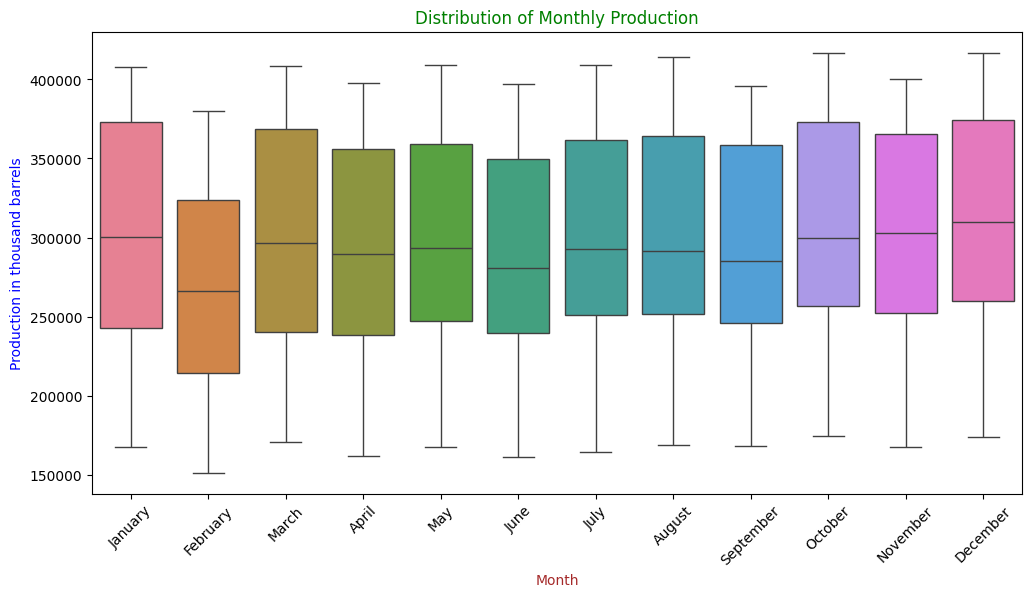

Monthly boxplot displayed.


In [353]:
# Plotting a boxplot of Production by Month
plt.figure(figsize=(12, 6))
print("Initialized monthly boxplot figure with size 12x6.")

sns.boxplot(x='Month', y='Production', data=df_filtered, palette='husl')
print("Boxplot of monthly production generated.")

# Formatting the plot
plt.title('Distribution of Monthly Production', color='green')
plt.xlabel('Month', color='brown')
plt.ylabel('Production in thousand barrels', color='blue')
plt.xticks(rotation=45)
print("Plot title, axis labels, and x-axis rotation set.")

# Display the plot
plt.show()
print("Monthly boxplot displayed.")

### Seasonality Plot

Year and Month parts extracted from Date column.
Initialized seasonal plot figure with size 12x6.
Preparing to plot 16 years with unique color palette.
All yearly production lines and labels plotted.
Plot title, labels, ticks, and grid set.


<function matplotlib.pyplot.show(close=None, block=None)>

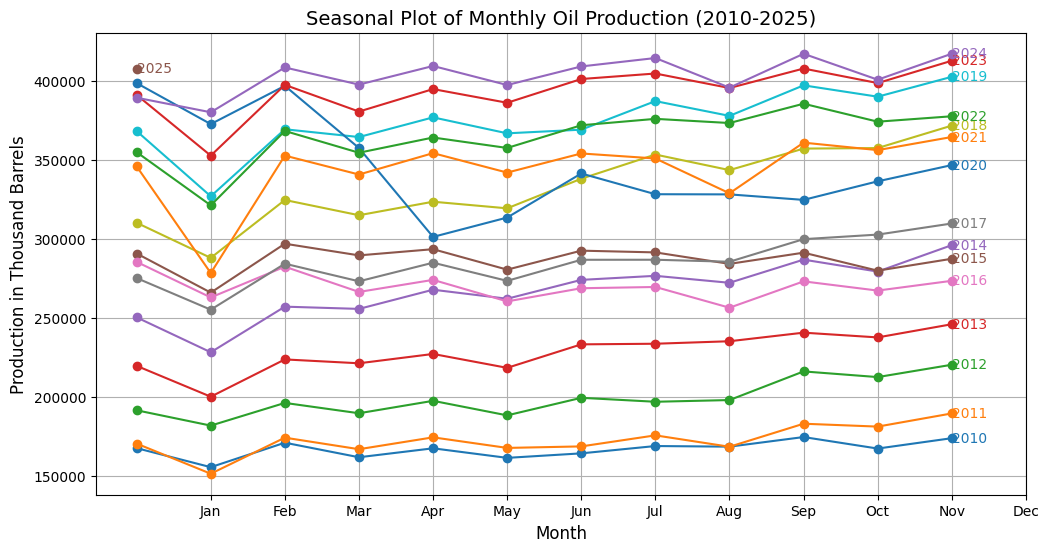

In [354]:
# Extracting year and month for seasonal plotting
df_filtered['Year_part'] = df_filtered['Date'].dt.year
df_filtered['Month_part'] = df_filtered['Date'].dt.month
print("Year and Month parts extracted from Date column.")

# Create a seasonal plot using Seaborn/Matplotlib
plt.figure(figsize=(12, 6))
print("Initialized seasonal plot figure with size 12x6.")

# Unique years present in the filtered data
years = df_filtered['Year'].unique()
palette = sns.color_palette("tab10", len(years))
print(f"Preparing to plot {len(years)} years with unique color palette.")

# Plot each year's monthly production trend
for i, year in enumerate(years):
    subset = df_filtered[df_filtered['Year'] == year]
    plt.plot(subset['Month'], subset['Production'], marker='o', color=palette[i], label=year)

    # Add label at the last point for each year
    plt.text(
        subset['Month'].iloc[-1],
        subset['Production'].iloc[-1],
        str(year),
        fontsize=10,
        color=palette[i],
        verticalalignment='center'
    )

print("All yearly production lines and labels plotted.")

# Formatting the plot
plt.title('Seasonal Plot of Monthly Oil Production (2010-2025)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Production in Thousand Barrels', fontsize=12)
plt.xticks(
    ticks=range(1, 13),
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
plt.grid(True)
print("Plot title, labels, ticks, and grid set.")

# Display the seasonal plot
plt.show

### Time Series Decomposition

Datetime index set for the DataFrame.
Columns for additive and multiplicative decomposition created.
Performing additive decomposition...
Performing multiplicative decomposition...
Plotting additive decomposition results...
Plotting multiplicative decomposition results...


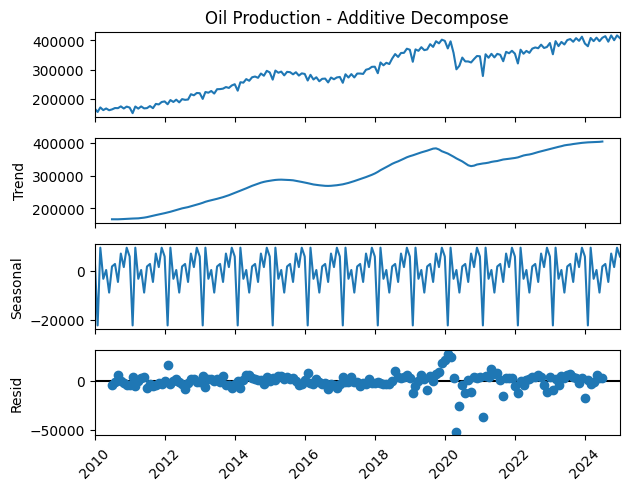

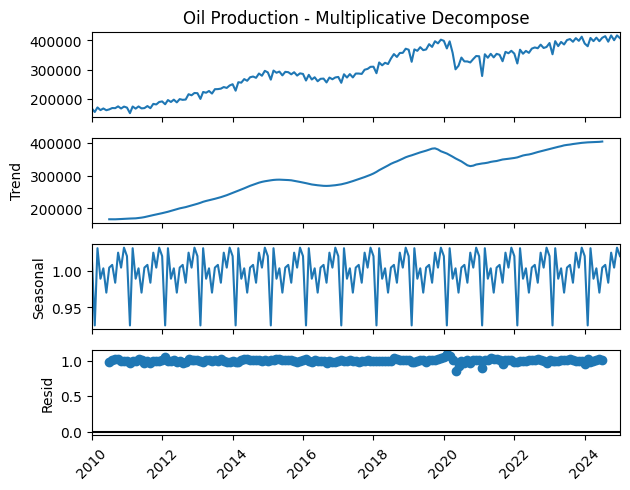

Decomposition plots displayed.


In [355]:
# Set 'Date' column as index for time series analysis
df_filtered = df_filtered.set_index('Date')
print("Datetime index set for the DataFrame.")

# Create separate columns for additive and multiplicative decomposition
df_filtered['Oil Production - Multiplicative Decompose'] = df_filtered['Production']
df_filtered['Oil Production - Additive Decompose'] = df_filtered['Production']
print("Columns for additive and multiplicative decomposition created.")

# Perform additive decomposition
print("Performing additive decomposition...")
result_add = seasonal_decompose(
    df_filtered['Oil Production - Additive Decompose'],
    model='additive',
    period=12
)

# Perform multiplicative decomposition
print("Performing multiplicative decomposition...")
result_mul = seasonal_decompose(
    df_filtered['Oil Production - Multiplicative Decompose'],
    model='multiplicative',
    period=12
)

# Plotting additive decomposition
print("Plotting additive decomposition results...")
result_add.plot()
plt.xticks(rotation=45)

# Plotting multiplicative decomposition
print("Plotting multiplicative decomposition results...")
result_mul.plot()
plt.xticks(rotation=45)

# Show all decomposition plots
plt.show()
print("Decomposition plots displayed.")

### Lag Analysis

Oil production series extracted.
Differencing applied to make the series stationary.
Plotting Partial Autocorrelation Function (PACF)...


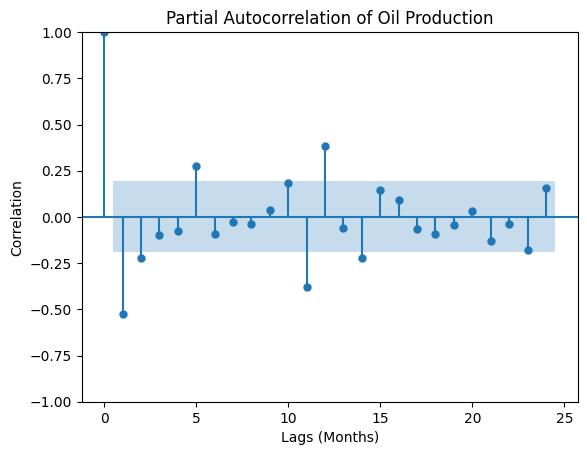

PACF plot displayed.


In [356]:
# Extract Oil Production series
oil_production = df_filtered['Production']
print("Oil production series extracted.")

# Apply first-order differencing to remove trend
oil_production_diff = oil_production.diff().dropna()
print("Differencing applied to make the series stationary.")

# Plot Partial Autocorrelation Function (PACF)
print("Plotting Partial Autocorrelation Function (PACF)...")
plot_pacf(oil_production_diff, lags=24, alpha=0.01)
plt.title('Partial Autocorrelation of Oil Production')
plt.ylabel('Correlation')
plt.xlabel('Lags (Months)')

# Display the PACF plot
plt.show()
print("PACF plot displayed.")

### Save data in csv and SQLlite Database

In [357]:
# Step 1: Create a connection to SQLite database (file will be created if it doesn't exist)
conn = sqlite3.connect('oil_production.db')
print("SQLite database connection established.")

# Step 2: Write the DataFrame to a SQL table named 'production_data'
df_filtered.to_sql('production_data', conn, if_exists='replace', index=False)
print("DataFrame written to 'production_data' table in SQLite database.")

# Step 3: Close the connection
conn.close()
print("SQLite database connection closed.")

# Save the DataFrame to a CSV file
df_filtered.to_csv('oil_production.csv', index=False)
print("Data saved to 'oil_production.csv'.")

SQLite database connection established.
DataFrame written to 'production_data' table in SQLite database.
SQLite database connection closed.
Data saved to 'oil_production.csv'.


# Part 2: Oil Production Forecasting — Modeling, Evaluation, and Selection

This phase involved building, evaluating, and selecting forecasting models using both classical time series techniques and machine learning approaches.

## 1. Data Preprocessing

- Created a datetime index from year and month components.
- Standardized to monthly frequency using 'Month Start' format.
- Cleaned and converted production values to numeric.
- Applied consistent formatting using a preprocessing function.

## 2. Evaluation Metrics

- Used RMSE, MAE, and MAPE to evaluate forecast accuracy.
- Metrics were normalized as percentages of the mean actual value for comparability across models.
- An evaluation function computed and returned all three metrics for each forecast.

## 3. Visualization and Summarization Tools

- Time series forecasts were visualized against actuals.
- Yearly and monthly confidence intervals (90% and 95%) were generated.
- Model results were summarized in interactive tables and ranked based on weighted performance scores.

## 4. Short-Term Forecasting

Models included in the short-term forecast comparison:

- ARIMA with STL decomposition
- Exponential Smoothing (ETS)
- SARIMA
- Facebook Prophet
- Hybrid STL + LSTM

A forecasting pipeline was used to train, evaluate, and compare each model. Model performance was ranked using a weighted scoring function that emphasized MAPE for short-term accuracy.

The top-ranked model was selected for final output, visualization, and confidence interval generation.

## 5. Model Persistence for Short-Term Forecasting

The best-performing short-term model was saved using a pickle file format. The user provided a split date, and the selected model was trained and persisted with that date encoded in the filename for traceability.

## 6. Long-Term Forecasting

Models compared for long-term forecasting included:

- XGBoost with lag-based feature engineering
- Hybrid STL + XGBoost
- Facebook Prophet with log transformation and monthly regressor
- Hybrid STL + LSTM

A separate long-term pipeline was run to generate forecasts for a 60-month horizon. Forecasts and actuals were aggregated annually to support trend-based analysis.

## 7. Model Persistence for Long-Term Forecasting

For long-term model saving, the user was prompted to provide a forecast start date. The forecast horizon was calculated dynamically, and the best-performing model was saved using the pickle format.

## 8. Final Outputs

- Forecast plots with actuals and confidence intervals
- Forecast summary tables with annual averages and uncertainty bounds
- Ranked model performance with weighted scoring
- Saved model files for both short- and long-term horizons

This concludes the modeling and evaluation phase.

In [358]:
!pip install prophet
!pip install scikit-learn tensorflow

#### Import necessary librarires

In [359]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib
from datetime import datetime
from datetime import timedelta

# Time Series Models
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Machine Learning
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

print("All forecasting and ML libraries imported successfully.")

All forecasting and ML libraries imported successfully.


#### Common Functions for both long and short term forecasting

In [360]:
# ---------- Data Preprocessing ---------- #
def preprocess_oil_data(df):
    """
    Preprocess oil production data by creating a datetime index,
    selecting relevant columns, and setting monthly frequency.
    """
    print("Starting data preprocessing...")

    # Combine Year and Month_part into a proper datetime column
    df['Date'] = pd.to_datetime(
        df['Year'].astype(str) + '-' + df['Month_part'].astype(str) + '-01'
    )
    print("Date column created from Year and Month_part.")

    # Select only Date and Production columns
    df = df[['Date', 'Production']]
    print("Filtered to Date and Production columns.")

    # Sort by Date and set Date as index with monthly frequency
    df = df.sort_values('Date').set_index('Date')
    df = df.asfreq('MS')  # 'MS' = Month Start
    print("Date column set as index with monthly frequency.")

    print("Data preprocessing completed.")
    df.to_csv("preprocessed_oil_data.csv", index=False)
    return df

In [361]:
df.head()

,Year,Month,Production,Date
0,1920,January,34008,1920-01-01
1,1920,February,33193,1920-02-01
2,1920,March,36171,1920-03-01
3,1920,April,34945,1920-04-01
4,1920,May,36622,1920-05-01


In [362]:
def evaluate_forecast(y_true, y_pred):
    """
    Evaluate forecast accuracy using RMSE, MAE, and MAPE metrics.
    Returns all metrics as percentages relative to the mean of the actual values.
    """
    print("Evaluating forecast...")

    mean_actual = np.mean(y_true)
    print(f"Mean of actual values: {mean_actual:.2f}")

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    results = {
        "RMSE (%)": float(round((rmse / mean_actual) * 100, 2)),
        "MAE (%)": float(round((mae / mean_actual) * 100, 2)),
        "MAPE (%)": float(round(mape * 100, 2))
    }

    print(f"Evaluation Results: {results}")
    return results

In [363]:
def rank_models(results, weights=None):
    """
    Rank forecasting models based on weighted normalized error metrics.

    Parameters:
    - results (dict): Dictionary of model names and their evaluation metric dicts.
    - weights (dict): Weights for each metric. If None, all metrics are equally weighted.

    Returns:
    - DataFrame: Sorted by WeightedScore (lower is better).
    """
    print("Ranking models based on performance metrics...")

    df = pd.DataFrame(results).T  # Transpose so models are rows
    print("Model results loaded into DataFrame.")

    # Default equal weights for each metric
    if weights is None:
        weights = {
            'RMSE (%)': 1.0,
            'MAE (%)': 1.0,
            'MAPE (%)': 1.0
        }
    print(f"Using weights: {weights}")

    # Normalize each metric using Min-Max scaling
    for metric in weights:
        min_val = df[metric].min()
        max_val = df[metric].max()
        if max_val != min_val:
            df[f'{metric}_norm'] = (df[metric] - min_val) / (max_val - min_val)
        else:
            df[f'{metric}_norm'] = 0.0  # Avoid division by zero
        print(f"{metric} normalized.")

    # Compute weighted score (lower is better)
    df['WeightedScore'] = sum(
        df[f'{metric}_norm'] * weight for metric, weight in weights.items()
    )
    print("Weighted scores calculated.")

    # Sort models by WeightedScore
    df_sorted = df.sort_values('WeightedScore')
    print("Models ranked by performance.\n")

    return df_sorted

In [364]:
def plot_forecast(dates, actual, forecast, label):
    """
    Plot actual vs forecasted values for a given model.

    Parameters:
    - dates (array-like): Sequence of dates.
    - actual (array-like): True production values.
    - forecast (array-like): Forecasted production values.
    - label (str): Name of the forecasting model.
    """
    print(f"Plotting forecast for model: {label}")

    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, label='Actual')
    plt.plot(dates, forecast, label=f'{label} Forecast')
    plt.title(f'{label} Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Production')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Forecast plot displayed.\n")

In [365]:
def plot_best_model_forecast(best_model, actual, forecast, start_date, end_date, freq='MS'):
    """
    Plot actual vs forecast for the best model with clean visuals.

    Parameters:
    - best_model (str): Name of the model (used in plot title).
    - actual (array-like): Actual values aligned to date range.
    - forecast (array-like): Forecasted values aligned to date range.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    - freq (str): Frequency of data ('MS' for monthly, 'YS' for yearly).
    """
    print(f"Preparing to plot forecast for best model: {best_model}")

    # Generate datetime index for plotting range
    dates = pd.date_range(start=start_date, end=end_date, freq=freq)

    # Convert forecasts and actuals to pandas Series
    forecast = pd.Series(forecast[:len(dates)], index=dates)
    actual = pd.Series(actual[:len(dates)], index=dates)

    # Aggregate to yearly if required
    if freq == 'YS':
        forecast = forecast.resample('Y').sum()
        actual = actual.resample('Y').sum()
        print("Resampled data to yearly frequency.")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual.values, label='Actual', color='black', linewidth=2)
    plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--', color='#0072B2', linewidth=2)

    # Formatting
    start_str = pd.to_datetime(start_date).strftime('%b %Y')
    end_str = pd.to_datetime(end_date).strftime('%b %Y')
    plt.title(
        f"{best_model} Forecast vs Actual\n({start_str} - {end_str})",
        fontsize=16,
        fontweight='bold'
    )
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Production", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)

    # X-axis formatting
    if freq == 'YS':
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    else:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.tight_layout()
    plt.show()
    print("Forecast vs actual plot displayed.\n")

In [366]:
def generate_forecast_table(best_model, forecast, metrics, start_date, end_date=None):
    """
    Generate a monthly forecast table with 90% and 95% confidence intervals estimated from MAPE.

    Parameters:
    - best_model (str): Name of the model used for the forecast.
    - forecast (array-like): Forecasted values for future periods.
    - metrics (dict): Evaluation metrics; must contain 'MAPE (%)'.
    - start_date (str): Forecast start date (format: 'YYYY-MM-DD').
    - end_date (str, optional): Ignored; periods are inferred from forecast length.

    Returns:
    - forecast_df (pd.DataFrame): Forecast table with confidence intervals.
    """
    import pandas as pd

    print(f"Generating forecast table for model: {best_model}")

    # Convert forecast to pandas Series
    forecast = pd.Series(forecast).reset_index(drop=True)
    print(f"Number of forecasted periods: {len(forecast)}")

    # Z-scores for confidence intervals
    z_90 = 1.645
    z_95 = 1.960

    # Estimate standard deviation using MAPE as proxy for relative error
    mape_pct = metrics.get('MAPE (%)', 10.0) / 100
    std_dev_est = forecast * mape_pct

    # Compute confidence intervals
    lower_90 = forecast - z_90 * std_dev_est
    upper_90 = forecast + z_90 * std_dev_est
    lower_95 = forecast - z_95 * std_dev_est
    upper_95 = forecast + z_95 * std_dev_est

    # Generate date range
    forecast_dates = pd.date_range(start=start_date, periods=len(forecast), freq='MS')

    # Construct the forecast DataFrame
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecast': forecast.round(2),
        'Lower 90% CI': lower_90.round(2),
        'Upper 90% CI': upper_90.round(2),
        'Lower 95% CI': lower_95.round(2),
        'Upper 95% CI': upper_95.round(2)
    })

    print("Forecast table generated successfully.")
    print(forecast_df.head())

    return forecast_df

#### Short term forecasting models

In [367]:
# ---------- ARIMA + STL ---------- #
def arima_with_stl(train, test):
    """
    Apply STL decomposition to remove seasonality and fit ARIMA on the trend+residuals.

    Parameters:
    - train (pd.Series): Training time series.
    - test (pd.Series): Testing time series.

    Returns:
    - forecast (np.ndarray): Forecasted values.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    """
    print("Starting STL decomposition...")
    stl = STL(train, period=12).fit()

    # Remove seasonal component
    detrended = train - stl.seasonal
    print("Seasonality removed from training data.")

    # Fit ARIMA on detrended data
    print("Fitting ARIMA(1,1,1) model...")
    model = ARIMA(detrended, order=(1, 1, 1)).fit()

    # Forecast the residual (detrended) component
    forecast_detrended = model.forecast(steps=len(test))
    print("ARIMA forecast on detrended data complete.")

    # Repeat last 12 months of seasonal component for test period
    seasonal_forecast = np.tile(
        stl.seasonal[-12:], int(np.ceil(len(test) / 12))
    )[:len(test)]
    forecast = forecast_detrended + seasonal_forecast
    print("Seasonality added back to forecast.")

    # Evaluate the forecast
    metrics = evaluate_forecast(test, forecast)
    print(f"Forecast evaluation metrics: {metrics}\n")

    return forecast, metrics

In [368]:
# ---------- Exponential Smoothing ---------- #
def exponential_smoothing_forecast(train, test):
    """
    Fit an Exponential Smoothing model and forecast future values.

    Parameters:
    - train (pd.Series): Training time series data.
    - test (pd.Series): Testing time series data.

    Returns:
    - forecast (np.ndarray): Forecasted values.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    - model (HoltWintersResultsWrapper): Trained model object.
    """
    print("Fitting Exponential Smoothing model (additive trend & seasonality)...")

    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=12
    ).fit()

    print("Model fitted successfully. Generating forecast...")
    forecast = model.forecast(steps=len(test))

    metrics = evaluate_forecast(test, forecast)
    print(f"Forecast evaluation metrics: {metrics}\n")

    return forecast, metrics, model

In [369]:
# ---------- SARIMA ---------- #
def sarima_forecast(train, test):
    """
    Fit a SARIMA model and forecast future values.

    Parameters:
    - train (pd.Series): Training time series data.
    - test (pd.Series): Testing time series data.

    Returns:
    - forecast (np.ndarray): Forecasted values.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    """
    print("Fitting SARIMA model with order=(1,1,1) and seasonal_order=(1,1,1,12)...")

    model = SARIMAX(
        train,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12)
    ).fit(disp=False)

    print("Model fitted. Generating forecast...")
    forecast = model.forecast(steps=len(test))

    metrics = evaluate_forecast(test, forecast)
    print(f"Forecast evaluation metrics: {metrics}\n")

    return forecast, metrics

In [370]:
def prophet_forecast(train_df, test_df):
    """
    Fit a Prophet model and generate forecasts for the test period.

    Parameters:
    - train_df (pd.DataFrame): Training data with 'Date' index and 'Production' column.
    - test_df (pd.DataFrame): Test data with 'Date' index and 'Production' column.

    Returns:
    - forecast_values (np.ndarray): Forecasted values.
    - actual_values (pd.Series): Actual test values.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    """
    print("Preparing data for Prophet...")
    df_prophet = train_df.reset_index().rename(columns={'Date': 'ds', 'Production': 'y'})

    print("Fitting Prophet model with yearly seasonality...")
    model = Prophet(yearly_seasonality=True)
    model.fit(df_prophet)

    # Forecast into future
    n_periods = len(test_df)
    future = model.make_future_dataframe(periods=n_periods, freq='MS')
    print(f"Forecasting {n_periods} future periods...")

    forecast = model.predict(future)
    forecast_series = forecast.set_index('ds')['yhat'][-n_periods:]

    metrics = evaluate_forecast(test_df['Production'], forecast_series.values)
    print(f"Forecast evaluation metrics: {metrics}\n")

    return forecast_series.values, test_df['Production'], metrics

In [371]:
def lstm_forecast(train, test, look_back=12):
    """
    Forecast using STL decomposition + LSTM on residuals.

    Parameters:
    - train (pd.Series): Training time series data.
    - test (pd.Series): Test time series data.
    - look_back (int): Number of past observations to use for LSTM input.

    Returns:
    - final_forecast (np.ndarray): Final forecasted values.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    """
    print("Starting STL decomposition...")
    stl = STL(train, period=12).fit()
    seasonal = stl.seasonal
    resid = train - seasonal
    print("Seasonal component extracted and removed.")

    # Combine residuals and test data for scaling
    print("Normalizing residual data...")
    data = pd.concat([resid, test])
    values = data.values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    # Create LSTM sequences
    def create_sequences(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        return np.array(X), np.array(y)

    split_index = len(resid)
    train_scaled = scaled[:split_index + look_back]
    test_scaled = scaled[split_index:]
    X_train, y_train = create_sequences(train_scaled, look_back)
    print(f"Training LSTM with {X_train.shape[0]} sequences...")

    # Define and train LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, verbose=0)
    print("LSTM model training complete.")

    # Generate test input sequences using sliding window
    X_test = []
    last_window = train_scaled[-look_back:]
    for i in range(len(test)):
        X_test.append(last_window)
        last_window = np.append(last_window[1:], test_scaled[i]).reshape(look_back, 1)
    X_test = np.array(X_test)

    print("Generating LSTM predictions...")
    pred_scaled = model.predict(X_test, verbose=0).flatten()
    pred_resid = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # Add seasonal component back
    seasonal_last = seasonal[-12:]
    seasonal_forecast = np.tile(
        seasonal_last.values, int(np.ceil(len(test) / 12))
    )[:len(test)]
    final_forecast = pred_resid + seasonal_forecast
    print("Final forecast reconstructed by adding back seasonality.")

    metrics = evaluate_forecast(test.values, final_forecast)
    print(f"Forecast evaluation metrics: {metrics}\n")

    return final_forecast, metrics

Preprocessing raw oil data...
Starting data preprocessing...
Date column created from Year and Month_part.
Filtered to Date and Production columns.
Date column set as index with monthly frequency.
Data preprocessing completed.
Starting STL decomposition...
Seasonality removed from training data.
Fitting ARIMA(1,1,1) model...
ARIMA forecast on detrended data complete.
Seasonality added back to forecast.
Evaluating forecast...
Mean of actual values: 403238.85
Evaluation Results: {'RMSE (%)': 2.72, 'MAE (%)': 2.27, 'MAPE (%)': 2.29}
Forecast evaluation metrics: {'RMSE (%)': 2.72, 'MAE (%)': 2.27, 'MAPE (%)': 2.29}

Plotting forecast for model: ARIMA + STL


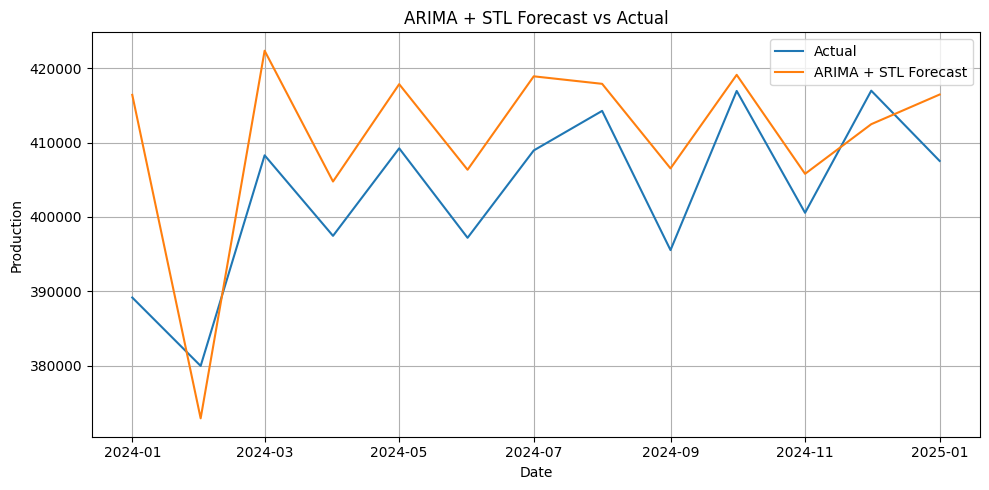

Forecast plot displayed.

ARIMA + STL Metrics: {'RMSE (%)': 2.72, 'MAE (%)': 2.27, 'MAPE (%)': 2.29}
Fitting Exponential Smoothing model (additive trend & seasonality)...
Model fitted successfully. Generating forecast...
Evaluating forecast...
Mean of actual values: 403238.85
Evaluation Results: {'RMSE (%)': 1.89, 'MAE (%)': 1.42, 'MAPE (%)': 1.43}
Forecast evaluation metrics: {'RMSE (%)': 1.89, 'MAE (%)': 1.42, 'MAPE (%)': 1.43}

Plotting forecast for model: Exponential Smoothing


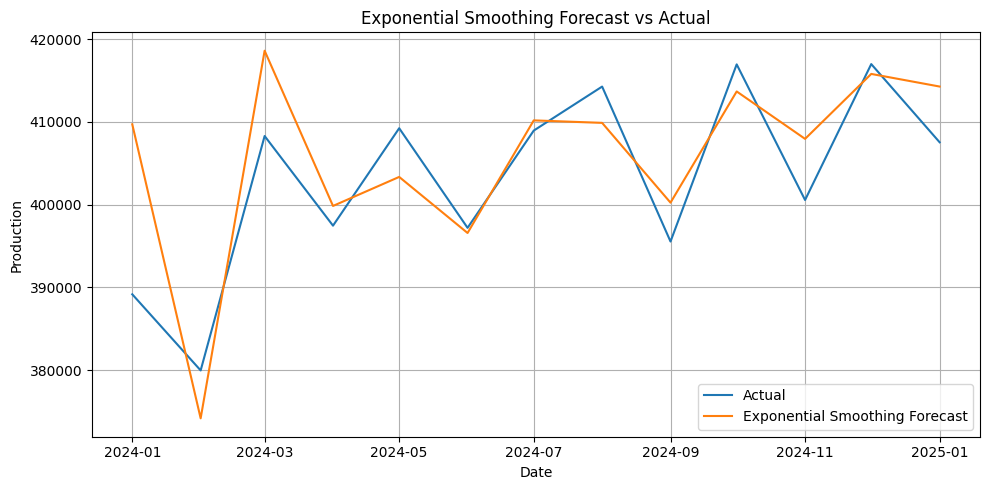

Forecast plot displayed.

ETS Metrics: {'RMSE (%)': 1.89, 'MAE (%)': 1.42, 'MAPE (%)': 1.43}
Fitting SARIMA model with order=(1,1,1) and seasonal_order=(1,1,1,12)...
Model fitted. Generating forecast...
Evaluating forecast...
Mean of actual values: 403238.85
Evaluation Results: {'RMSE (%)': 4.17, 'MAE (%)': 3.69, 'MAPE (%)': 3.69}
Forecast evaluation metrics: {'RMSE (%)': 4.17, 'MAE (%)': 3.69, 'MAPE (%)': 3.69}

Plotting forecast for model: SARIMA


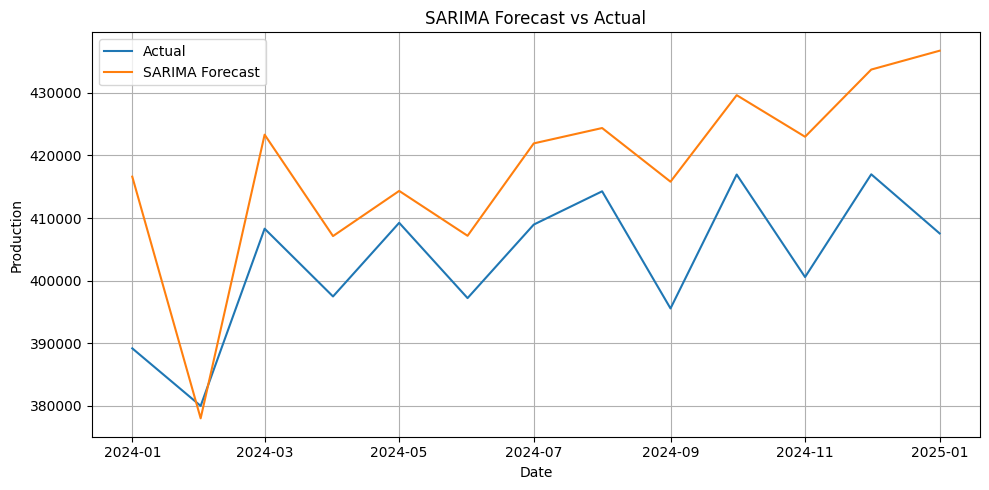

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujmbe6vo/zy9lj3fg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujmbe6vo/rcf5i2q2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95544', 'data', 'file=/tmp/tmpujmbe6vo/zy9lj3fg.json', 'init=/tmp/tmpujmbe6vo/rcf5i2q2.json', 'output', 'file=/tmp/tmpujmbe6vo/prophet_modell4ky2xmj/prophet_model-20250420114204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:42:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:42:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast plot displayed.

SARIMA Metrics: {'RMSE (%)': 4.17, 'MAE (%)': 3.69, 'MAPE (%)': 3.69}
Preparing data for Prophet...
Fitting Prophet model with yearly seasonality...
Forecasting 13 future periods...
Evaluating forecast...
Mean of actual values: 403238.85
Evaluation Results: {'RMSE (%)': 2.91, 'MAE (%)': 2.49, 'MAPE (%)': 2.48}
Forecast evaluation metrics: {'RMSE (%)': 2.91, 'MAE (%)': 2.49, 'MAPE (%)': 2.48}

Plotting forecast for model: Prophet


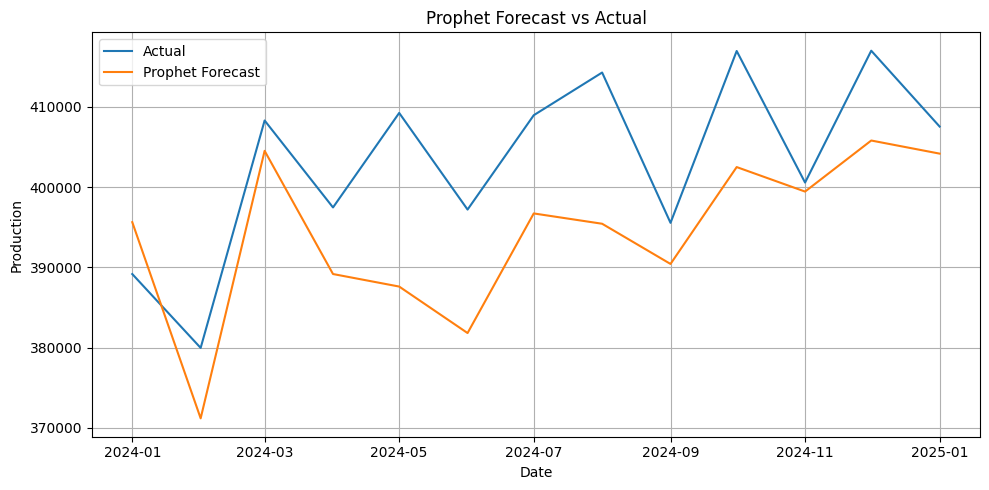

Forecast plot displayed.

Prophet Metrics: {'RMSE (%)': 2.91, 'MAE (%)': 2.49, 'MAPE (%)': 2.48}
Starting STL decomposition...
Seasonal component extracted and removed.
Normalizing residual data...
Training LSTM with 168 sequences...
LSTM model training complete.
Generating LSTM predictions...
Final forecast reconstructed by adding back seasonality.
Evaluating forecast...
Mean of actual values: 403238.85
Evaluation Results: {'RMSE (%)': 2.51, 'MAE (%)': 1.79, 'MAPE (%)': 1.82}
Forecast evaluation metrics: {'RMSE (%)': 2.51, 'MAE (%)': 1.79, 'MAPE (%)': 1.82}

Plotting forecast for model: LSTM


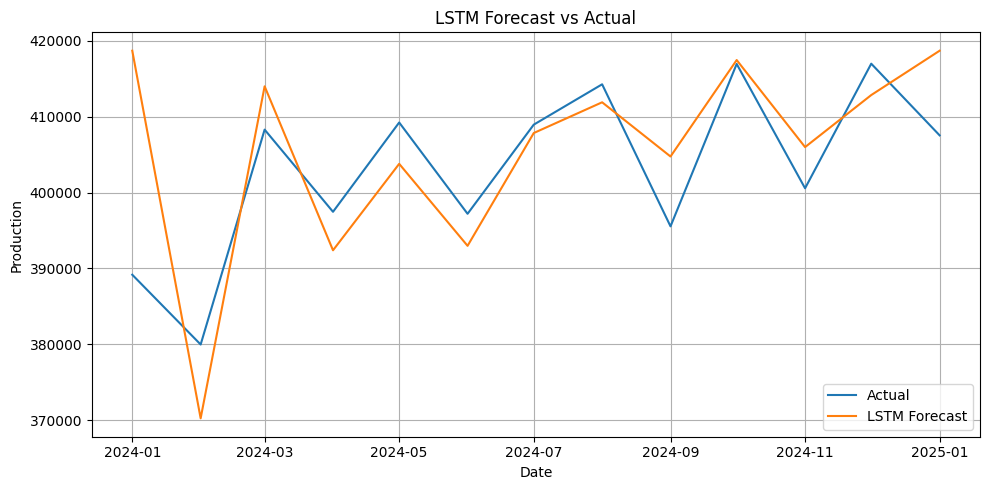

Forecast plot displayed.

LSTM Metrics: {'RMSE (%)': 2.51, 'MAE (%)': 1.79, 'MAPE (%)': 1.82}
All models evaluated.


Model Performance (Unranked):
             RMSE (%)  MAE (%)  MAPE (%)
ARIMA + STL      2.72     2.27      2.29
ETS              1.89     1.42      1.43
SARIMA           4.17     3.69      3.69
Prophet          2.91     2.49      2.48
LSTM             2.51     1.79      1.82

Ranking models based on weighted metrics...
Ranking models based on performance metrics...
Model results loaded into DataFrame.
Using weights: {'RMSE (%)': 1.0, 'MAE (%)': 1.0, 'MAPE (%)': 2.0}
RMSE (%) normalized.
MAE (%) normalized.
MAPE (%) normalized.
Weighted scores calculated.
Models ranked by performance.


Best Model: ETS

Model Performance Summary:
             RMSE (%)  MAE (%)  MAPE (%)  WeightedScore
ETS              1.89     1.42      1.43       0.000000
LSTM             2.51     1.79      1.82       0.780058
ARIMA + STL      2.72     2.27      2.29       1.499546
Prophet          2.91

In [372]:
# ---------- Master Pipeline ---------- #
def run_oil_shortterm_forecasting_pipeline(df, split_date="2024-01-01"):
    """
    Runs a short-term forecasting pipeline using ARIMA+STL, ETS, SARIMA, Prophet, and LSTM.

    Parameters:
    - df (pd.DataFrame): Raw oil production DataFrame.
    - split_date (str): Date to split train and test sets.

    Returns:
    - results (dict): Model evaluation metrics.
    - forecasts (dict): Model forecasts.
    - test (pd.DataFrame): Actual test data.
    """
    print("Preprocessing raw oil data...")
    df = preprocess_oil_data(df)
    # Save to CSV
    df.head()
    train = df[df.index < split_date]
    test = df[df.index >= split_date]

    results = {}
    forecasts = {}

    # ----- ARIMA + STL -----
    arima_vals, arima_metrics = arima_with_stl(train['Production'], test['Production'])
    plot_forecast(test.index, test['Production'], arima_vals, "ARIMA + STL")
    print("ARIMA + STL Metrics:", arima_metrics)
    results['ARIMA + STL'] = arima_metrics
    forecasts['ARIMA + STL'] = arima_vals

    # ----- Exponential Smoothing (ETS) -----
    ets_vals, ets_metrics, _ = exponential_smoothing_forecast(train['Production'], test['Production'])
    plot_forecast(test.index, test['Production'], ets_vals, "Exponential Smoothing")
    print("ETS Metrics:", ets_metrics)
    results['ETS'] = ets_metrics
    forecasts['ETS'] = ets_vals

    # ----- SARIMA -----
    sarima_vals, sarima_metrics = sarima_forecast(train['Production'], test['Production'])
    plot_forecast(test.index, test['Production'], sarima_vals, "SARIMA")
    print("SARIMA Metrics:", sarima_metrics)
    results['SARIMA'] = sarima_metrics
    forecasts['SARIMA'] = sarima_vals

    # ----- Prophet -----
    prophet_vals, prophet_actual, prophet_metrics = prophet_forecast(train, test)
    plot_forecast(test.index, prophet_actual, prophet_vals, "Prophet")
    print("Prophet Metrics:", prophet_metrics)
    results['Prophet'] = prophet_metrics
    forecasts['Prophet'] = prophet_vals

    # ----- LSTM + STL -----
    lstm_vals, lstm_metrics = lstm_forecast(train['Production'], test['Production'])
    plot_forecast(test.index, test['Production'], lstm_vals, "LSTM")
    print("LSTM Metrics:", lstm_metrics)
    results['LSTM'] = lstm_metrics
    forecasts['LSTM'] = lstm_vals

    print("All models evaluated.\n")
    return results, forecasts, test


# ---------------------- Run Pipeline ---------------------- #
df_raw = pd.read_csv("oil_production.csv")
results, forecasts, test = run_oil_shortterm_forecasting_pipeline(df_raw)

# Display raw metrics
print("\nModel Performance (Unranked):")
print(pd.DataFrame(results).T)

# ---------------------- Rank Models ---------------------- #
print("\nRanking models based on weighted metrics...")
ranked_df = rank_models(results, weights={
    'RMSE (%)': 1.0,
    'MAE (%)': 1.0,
    'MAPE (%)': 2.0  # emphasize short-term accuracy
})

# Extract best model
best_model_shortterm = ranked_df.index[0]
best_forecast_shortterm = forecasts[best_model_shortterm]
best_metrics_shortterm = results[best_model_shortterm]

# Print final results
print(f"\nBest Model: {best_model_shortterm}")
print("\nModel Performance Summary:")
print(ranked_df[['RMSE (%)', 'MAE (%)', 'MAPE (%)', 'WeightedScore']])

#### Best Short Term Model

Preparing to plot forecast for best model: ETS


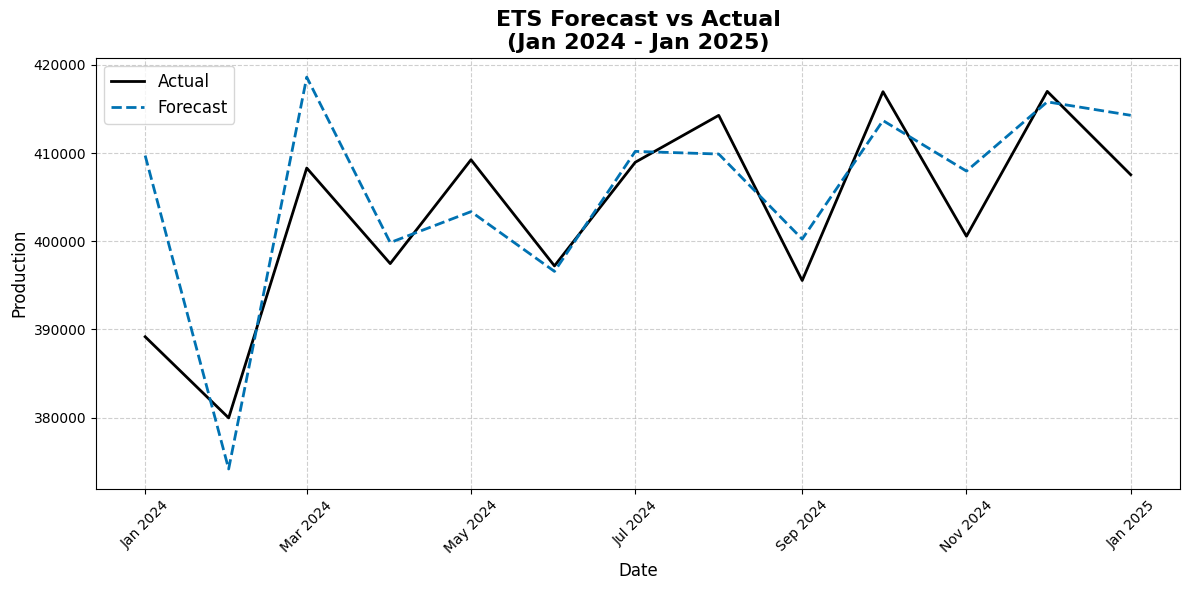

Forecast vs actual plot displayed.

Generating forecast table for model: ETS
Number of forecasted periods: 13
Forecast table generated successfully.
        Date   Forecast  Lower 90% CI  Upper 90% CI  Lower 95% CI  \
0 2024-01-01  409707.95     400070.19     419345.72     398224.66   
1 2024-02-01  374168.47     365366.72     382970.22     363681.28   
2 2024-03-01  418604.98     408757.93     428452.04     406872.32   
3 2024-04-01  399841.57     390435.89     409247.24     388634.81   
4 2024-05-01  403349.22     393861.03     412837.41     392044.15   

   Upper 95% CI  
0     421191.25  
1     384655.66  
2     430337.64  
3     411048.33  
4     414654.29  

Forecast Table - ETS (with Confidence Intervals):


,Date,Forecast,Lower 90% CI,Upper 90% CI,Lower 95% CI,Upper 95% CI
0,2024-01-01,409707.95,400070.19,419345.72,398224.66,421191.25
1,2024-02-01,374168.47,365366.72,382970.22,363681.28,384655.66
2,2024-03-01,418604.98,408757.93,428452.04,406872.32,430337.64
3,2024-04-01,399841.57,390435.89,409247.24,388634.81,411048.33
4,2024-05-01,403349.22,393861.03,412837.41,392044.15,414654.29
5,2024-06-01,396572.82,387244.04,405901.61,385457.68,407687.97
6,2024-07-01,410184.16,400535.20,419833.13,398687.52,421680.81
7,2024-08-01,409883.33,400241.44,419525.22,398395.12,421371.54
8,2024-09-01,400239.15,390824.13,409654.18,389021.25,411457.06
9,2024-10-01,413679.63,403948.44,423410.82,402085.02,425274.24


In [373]:
# Plot the best model's forecast vs actuals
plot_best_model_forecast(
    best_model=best_model_shortterm,
    actual=test['Production'],
    forecast=best_forecast_shortterm,
    start_date='2024-01-01',
    end_date='2025-01-01',
    freq='MS'  # Monthly frequency
)

# Generate forecast table with confidence intervals
forecast_df = generate_forecast_table(
    best_model=best_model_shortterm,
    forecast=best_forecast_shortterm,
    metrics=best_metrics_shortterm,
    start_date='2024-01-01',
    end_date='2025-01-01'
)

# Display forecast with 90% and 95% confidence intervals
print(f"\nForecast Table - {best_model_shortterm} (with Confidence Intervals):")
display(forecast_df[['Date', 'Forecast', 'Lower 90% CI', 'Upper 90% CI', 'Lower 95% CI', 'Upper 95% CI']])

In [374]:
# Ask user for split date
split_date_input = input("Enter the split date for train/test (YYYY-MM-DD): ")

# Basic validation
try:
    # Try converting to datetime to ensure valid format
    split_date = pd.to_datetime(split_date_input).strftime('%Y-%m-%d')
except ValueError:
    raise ValueError("Invalid date format. Please use YYYY-MM-DD.")

# Load and preprocess data
df = pd.read_csv("oil_production.csv")
df = preprocess_oil_data(df)

# Train-test split
train = df[df.index < split_date]
test = df[df.index >= split_date]

print(f"\nData split completed.\nTraining samples: {len(train)}\nTesting samples: {len(test)}")

# Run ETS model
ets_vals, ets_metrics, model = exponential_smoothing_forecast(train['Production'], test['Production'])

# Save the ETS model as a .pkl file
joblib.dump(model, 'best_shortterm_model_ets.pkl')
print("\nETS model saved successfully as 'best_shortterm_model_ets.pkl'")

Enter the split date for train/test (YYYY-MM-DD): 2024-01-01
Starting data preprocessing...
Date column created from Year and Month_part.
Filtered to Date and Production columns.
Date column set as index with monthly frequency.
Data preprocessing completed.

Data split completed.
Training samples: 168
Testing samples: 13
Fitting Exponential Smoothing model (additive trend & seasonality)...
Model fitted successfully. Generating forecast...
Evaluating forecast...
Mean of actual values: 403238.85
Evaluation Results: {'RMSE (%)': 1.89, 'MAE (%)': 1.42, 'MAPE (%)': 1.43}
Forecast evaluation metrics: {'RMSE (%)': 1.89, 'MAE (%)': 1.42, 'MAPE (%)': 1.43}


ETS model saved successfully as 'best_shortterm_model_ets.pkl'


#### Long term forecasting Models

In [375]:
# ------------------ Feature Engineering ------------------ #
def create_features(df, lags=[1, 2, 3, 6, 12]):
    """
    Generate lag-based time series features for forecasting models.

    Parameters:
    - df (pd.DataFrame): Time series DataFrame with 'Production' and datetime index.
    - lags (list): List of lag periods to create features for.

    Returns:
    - df_feat (pd.DataFrame): Feature-engineered DataFrame with lag features.
    """
    print("Creating time series features...")

    df_feat = df.copy()
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    print("Added 'month' and 'year' features.")

    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['Production'].shift(lag)
        print(f"Added lag feature: lag_{lag}")

    df_feat.dropna(inplace=True)
    print(f"Final feature set created with shape: {df_feat.shape}\n")

    return df_feat

In [376]:
# ------------------ XGBoost Forecast ------------------ #
def xgboost_forecast(df, forecast_horizon=60):
    """
    Perform time series forecasting using lag-based features and XGBoost.

    Parameters:
    - df (pd.DataFrame): DataFrame with a datetime index and 'Production' column.
    - forecast_horizon (int): Number of future periods to forecast.

    Returns:
    - y_pred (np.ndarray): Predicted values.
    - y_true (np.ndarray): Actual values.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    """
    print("Generating features for XGBoost...")
    df_feat = create_features(df)

    # Split into train/test
    train = df_feat.iloc[:-forecast_horizon]
    test = df_feat.iloc[-forecast_horizon:]
    print(f"Train size: {train.shape[0]}, Test size: {test.shape[0]}")

    # Separate features and target
    X_train, y_train = train.drop(columns='Production'), train['Production']
    X_test, y_test = test.drop(columns='Production'), test['Production']

    # Train XGBoost model
    print("Training XGBoost model...")
    model = XGBRegressor(n_estimators=500, learning_rate=0.05)
    model.fit(X_train, y_train)
    print("Model training complete. Generating forecast...")

    y_pred = model.predict(X_test)
    metrics = evaluate_forecast(y_test, y_pred)

    print(f"Forecast evaluation metrics: {metrics}\n")
    return y_pred, y_test.values, metrics

In [377]:
# ------------------ Hybrid STL + XGBoost ------------------ #
def hybrid_stl_xgboost(df, forecast_horizon=60):
    """
    Perform hybrid forecasting using STL decomposition and XGBoost on residuals.

    Parameters:
    - df (pd.DataFrame): DataFrame with datetime index and 'Production' column.
    - forecast_horizon (int): Number of future periods to forecast.

    Returns:
    - final_forecast (np.ndarray): Forecasted production values.
    - actual_with_seasonal (np.ndarray): Actual values with seasonality added back.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    - model (XGBRegressor): Trained XGBoost model.
    """
    print("Starting STL decomposition...")
    stl = STL(df['Production'], period=12).fit()
    seasonal = stl.seasonal
    resid = df['Production'] - seasonal
    print("Seasonal component extracted and residuals computed.")

    # Prepare residual DataFrame for feature engineering
    df_resid = pd.DataFrame({'Residual': resid})
    df_resid.index = df.index
    df_feat = create_features(df_resid.rename(columns={'Residual': 'Production'}))
    print("Lag-based features created from residuals.")

    # Train-test split
    train = df_feat.iloc[:-forecast_horizon]
    test = df_feat.iloc[-forecast_horizon:]
    print(f"Train size: {train.shape[0]}, Test size: {test.shape[0]}")

    X_train, y_train = train.drop(columns='Production'), train['Production']
    X_test, y_test = test.drop(columns='Production'), test['Production']

    # Train XGBoost model on residuals
    print("Training XGBoost on residuals...")
    model = XGBRegressor(n_estimators=500, learning_rate=0.05)
    model.fit(X_train, y_train)
    print("XGBoost model trained.")

    # Forecast residuals
    resid_pred = model.predict(X_test)

    # Reconstruct final forecast by adding back seasonal component
    seasonal_forecast = np.tile(seasonal[-12:], int(np.ceil(forecast_horizon / 12)))[:forecast_horizon]
    final_forecast = resid_pred + seasonal_forecast
    actual_with_seasonal = y_test.values + seasonal_forecast
    print("Final forecast reconstructed by adding seasonality.")

    # Evaluate forecast
    metrics = evaluate_forecast(actual_with_seasonal, final_forecast)
    print(f"Forecast evaluation metrics: {metrics}\n")

    return final_forecast, actual_with_seasonal, metrics, model

In [378]:
def prophet_forecast_longterm(df, forecast_months=60):
    """
    Perform long-term forecasting using Prophet with monthly seasonality and log-transformed production.

    Parameters:
    - df (pd.DataFrame): Time series data with datetime index and 'Production' column.
    - forecast_months (int): Number of future months to forecast.

    Returns:
    - forecast_series.values (np.ndarray): Forecasted production values.
    - actual_series (pd.Series): Actual production values for comparison.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    """
    print("Preparing data for Prophet long-term forecast...")

    # Prepare the dataframe for Prophet
    df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Production': 'y'})
    df_prophet['month'] = df_prophet['ds'].dt.month

    # Log transform target to stabilize variance
    df_prophet['y'] = np.log(df_prophet['y'])
    print("Log transformation applied to target variable.")

    # Initialize Prophet model and add 'month' as regressor
    model = Prophet(yearly_seasonality=True)
    model.add_regressor('month')
    model.fit(df_prophet)
    print("Prophet model trained with monthly seasonality.")

    # Create future DataFrame
    future = model.make_future_dataframe(periods=forecast_months, freq='MS')
    future['month'] = future['ds'].dt.month
    print(f"Future dataframe created for {forecast_months} months.")

    # Predict and reverse log transformation
    forecast = model.predict(future)
    forecast['yhat'] = np.exp(forecast['yhat'])  # inverse of log
    print("Forecast generated and log-transformed values reverted.")

    # Extract last forecast_months predictions and actuals
    forecast_series = forecast.set_index('ds')['yhat'][-forecast_months:]
    actual_series = df['Production'][-forecast_months:]

    # Evaluate model performance
    metrics = evaluate_forecast(actual_series.values, forecast_series.values)
    print(f"Forecast evaluation metrics: {metrics}\n")

    return forecast_series.values, actual_series, metrics

In [379]:
# ------------------ STL + LSTM ------------------ #
def stl_lstm_forecast(df, forecast_months=60, look_back=12):
    """
    Perform long-term forecasting using STL decomposition + LSTM on residuals.

    Parameters:
    - df (pd.DataFrame): DataFrame with 'Production' and datetime index.
    - forecast_months (int): Number of future months to forecast.
    - look_back (int): Number of time steps to use for LSTM input.

    Returns:
    - final_forecast (np.ndarray): Forecasted values.
    - actual (pd.Series): Actual production values for evaluation.
    - metrics (dict): Evaluation metrics (RMSE, MAE, MAPE).
    """
    print("Starting STL decomposition...")
    stl = STL(df['Production'], period=12).fit()
    resid = df['Production'] - stl.seasonal
    seasonal = stl.seasonal
    print("Seasonality removed and residuals extracted.")

    # Prepare scaled data
    full_data = pd.concat([resid, df['Production']], axis=1).dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(full_data.iloc[:, 0].values.reshape(-1, 1))
    print("Residuals normalized.")

    # Create LSTM sequences
    def create_lstm_sequences(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        return np.array(X), np.array(y)

    X, y = create_lstm_sequences(scaled, look_back)
    print(f"LSTM training sequences created: {X.shape[0]} samples.")

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=50, verbose=0)
    print("LSTM model trained.")

    # Forecast residuals
    last_input = scaled[-look_back:].reshape(1, look_back, 1)
    pred_scaled = []
    for _ in range(forecast_months):
        pred = model.predict(last_input, verbose=0)[0][0]
        pred_scaled.append(pred)
        last_input = np.append(last_input[:, 1:, :], [[[pred]]], axis=1)

    pred_resid = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1)).flatten()
    print("Residual forecast generated.")

    # Add seasonal component back
    seasonal_forecast = np.tile(seasonal[-12:], int(np.ceil(forecast_months / 12)))[:forecast_months]
    final_forecast = pred_resid + seasonal_forecast
    print("Seasonality added back to residual forecast.")

    # Actual values for evaluation
    actual = df['Production'][-forecast_months:]
    metrics = evaluate_forecast(actual, final_forecast)
    print(f"Forecast evaluation metrics: {metrics}\n")

    return final_forecast, actual, metrics

Starting data preprocessing...
Date column created from Year and Month_part.
Filtered to Date and Production columns.
Date column set as index with monthly frequency.
Data preprocessing completed.

 Running XGBoost Forecast...
Generating features for XGBoost...
Creating time series features...
Added 'month' and 'year' features.
Added lag feature: lag_1
Added lag feature: lag_2
Added lag feature: lag_3
Added lag feature: lag_6
Added lag feature: lag_12
Final feature set created with shape: (169, 8)

Train size: 109, Test size: 60
Training XGBoost model...
Model training complete. Generating forecast...
Evaluating forecast...
Mean of actual values: 370227.33
Evaluation Results: {'RMSE (%)': 7.33, 'MAE (%)': 4.74, 'MAPE (%)': 5.18}
Forecast evaluation metrics: {'RMSE (%)': 7.33, 'MAE (%)': 4.74, 'MAPE (%)': 5.18}

Plotting forecast for model: XGBoost


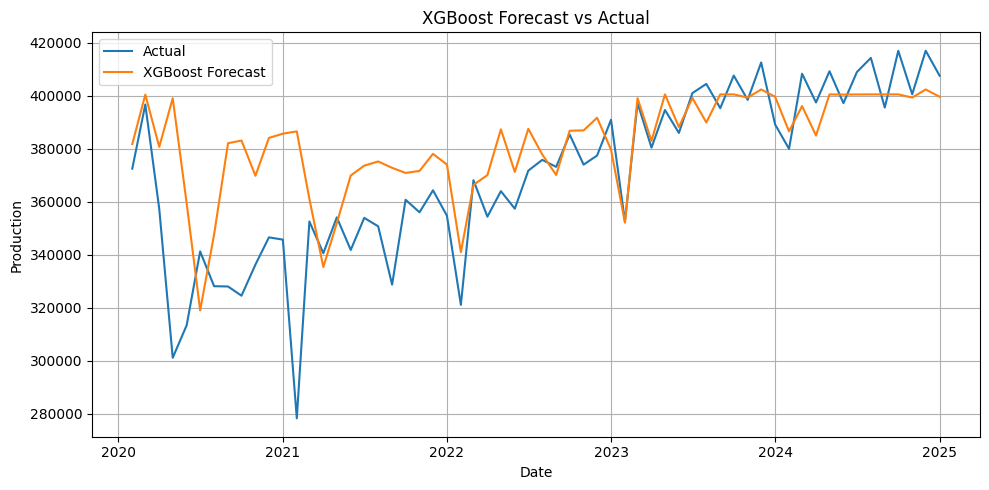

Forecast plot displayed.

XGBoost Metrics: {'RMSE (%)': 7.33, 'MAE (%)': 4.74, 'MAPE (%)': 5.18}

 Running Hybrid STL + XGBoost Forecast...
Starting STL decomposition...
Seasonal component extracted and residuals computed.
Creating time series features...
Added 'month' and 'year' features.
Added lag feature: lag_1
Added lag feature: lag_2
Added lag feature: lag_3
Added lag feature: lag_6
Added lag feature: lag_12
Final feature set created with shape: (169, 8)

Lag-based features created from residuals.
Train size: 109, Test size: 60
Training XGBoost on residuals...
XGBoost model trained.
Final forecast reconstructed by adding seasonality.
Evaluating forecast...
Mean of actual values: 370277.56
Evaluation Results: {'RMSE (%)': 5.14, 'MAE (%)': 4.11, 'MAPE (%)': 4.12}
Forecast evaluation metrics: {'RMSE (%)': 5.14, 'MAE (%)': 4.11, 'MAPE (%)': 4.12}

Plotting forecast for model: STL + XGBoost Hybrid


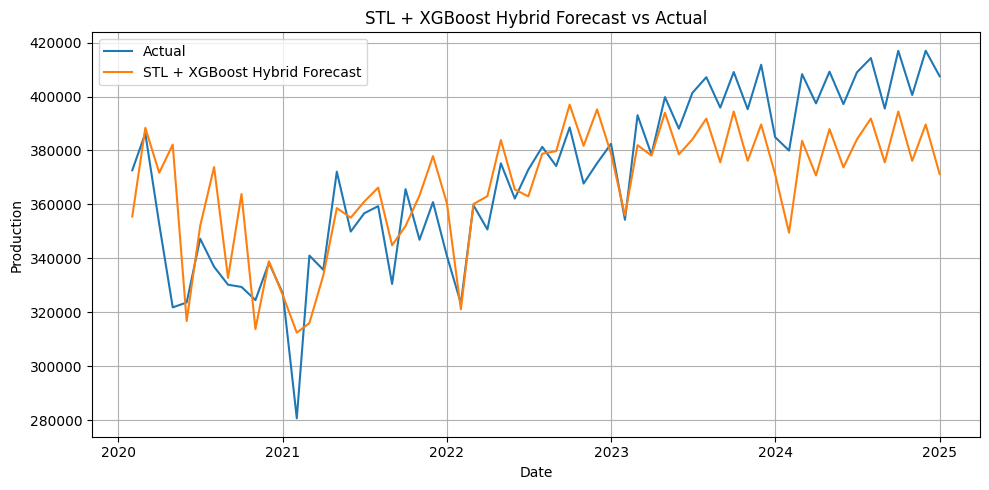

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujmbe6vo/1mddqy2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujmbe6vo/cwdmp38p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2757', 'data', 'file=/tmp/tmpujmbe6vo/1mddqy2e.json', 'init=/tmp/tmpujmbe6vo/cwdmp38p.json', 'output', 'file=/tmp/tmpujmbe6vo/prophet_modela7sw9y0w/prophet_model-20250420114324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Forecast plot displayed.

Hybrid STL + XGBoost Metrics: {'RMSE (%)': 5.14, 'MAE (%)': 4.11, 'MAPE (%)': 4.12}

 Running Prophet Forecast...
Preparing data for Prophet long-term forecast...
Log transformation applied to target variable.


11:43:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet model trained with monthly seasonality.
Future dataframe created for 60 months.
Forecast generated and log-transformed values reverted.
Evaluating forecast...
Mean of actual values: 370227.33
Evaluation Results: {'RMSE (%)': 27.94, 'MAE (%)': 27.43, 'MAPE (%)': 27.64}
Forecast evaluation metrics: {'RMSE (%)': 27.94, 'MAE (%)': 27.43, 'MAPE (%)': 27.64}

Plotting forecast for model: Prophet Long Term


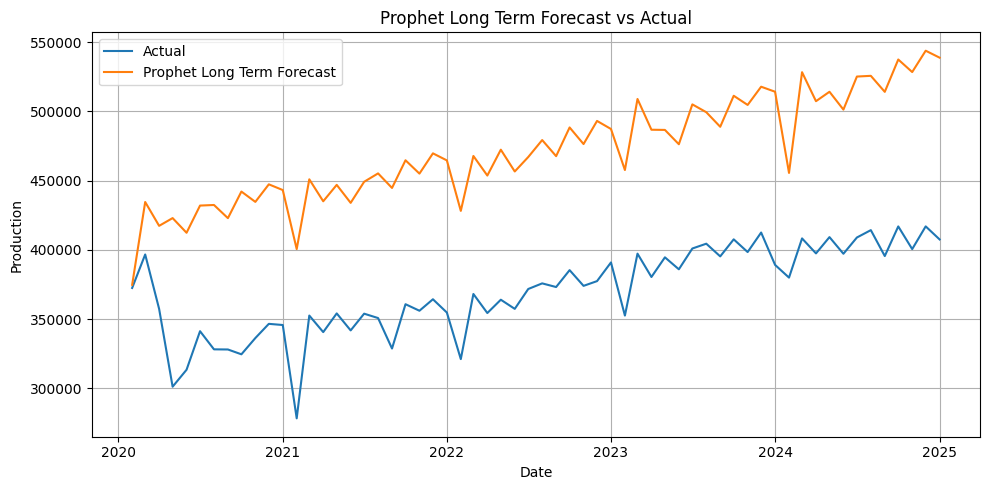

Forecast plot displayed.

Prophet Long Term Metrics: {'RMSE (%)': 27.94, 'MAE (%)': 27.43, 'MAPE (%)': 27.64}

 Running STL + LSTM Forecast...
Starting STL decomposition...
Seasonality removed and residuals extracted.
Residuals normalized.
LSTM training sequences created: 169 samples.
LSTM model trained.
Residual forecast generated.
Seasonality added back to residual forecast.
Evaluating forecast...
Mean of actual values: 370227.33
Evaluation Results: {'RMSE (%)': 28.77, 'MAE (%)': 27.45, 'MAPE (%)': 27.42}
Forecast evaluation metrics: {'RMSE (%)': 28.77, 'MAE (%)': 27.45, 'MAPE (%)': 27.42}

Plotting forecast for model: STL + LSTM Hybrid


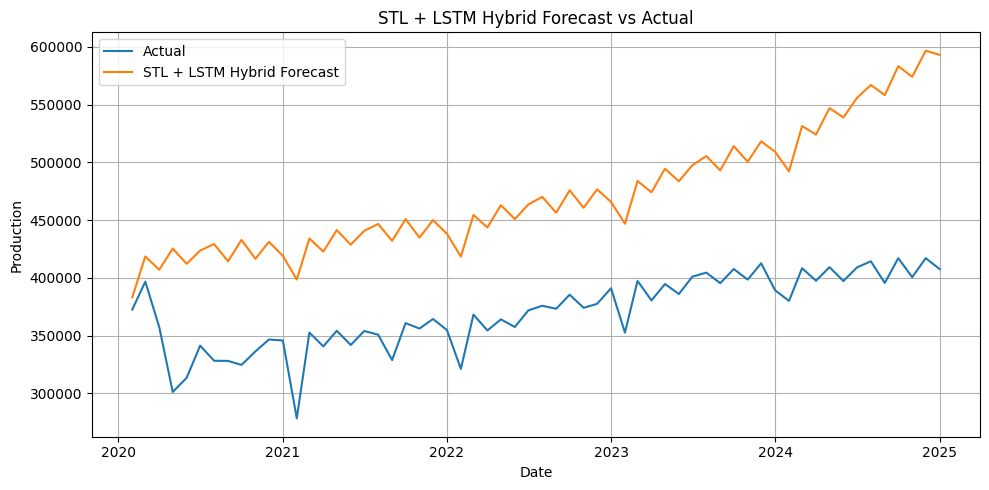

Forecast plot displayed.

STL + LSTM Hybrid Metrics: {'RMSE (%)': 28.77, 'MAE (%)': 27.45, 'MAPE (%)': 27.42}

 Ranking Long-Term Models...
Ranking models based on performance metrics...
Model results loaded into DataFrame.
Using weights: {'RMSE (%)': 2.0, 'MAE (%)': 1.5, 'MAPE (%)': 0.5}
RMSE (%) normalized.
MAE (%) normalized.
MAPE (%) normalized.
Weighted scores calculated.
Models ranked by performance.


 Best Model for Long-Term Forecasting: Hybrid STL + XGBoost

 Model Performance Summary:
                      RMSE (%)  MAE (%)  MAPE (%)  WeightedScore
Hybrid STL + XGBoost      5.14     4.11      4.12       0.000000
XGBoost                   7.33     4.74      5.18       0.248380
Prophet                  27.94    27.43     27.64       3.928465
STL + LSTM Hybrid        28.77    27.45     27.42       3.995323


In [380]:
def run_oil_longterm_forecasting_pipeline(df_raw, forecast_months=60):
    """
    Run long-term forecasting pipeline using XGBoost, Hybrid STL + XGBoost, Prophet, and STL + LSTM.

    Parameters:
    - df_raw (pd.DataFrame): Raw oil production data.
    - forecast_months (int): Number of months to forecast into the future.

    Returns:
    - ranked_df (pd.DataFrame): Ranked model performance.
    - forecasts (dict): Dictionary of forecasts and actuals by model.
    """
    df = preprocess_oil_data(df_raw)
    results = {}
    forecasts = {}

    # ---------- XGBoost ----------
    print("\n Running XGBoost Forecast...")
    xgb_pred, xgb_actual, xgb_metrics = xgboost_forecast(df, forecast_horizon=forecast_months)
    plot_forecast(df.index[-forecast_months:], xgb_actual, xgb_pred, "XGBoost")
    print("XGBoost Metrics:", xgb_metrics)
    results["XGBoost"] = xgb_metrics
    forecasts["XGBoost"] = {"pred": xgb_pred, "actual": xgb_actual}

    # ---------- Hybrid STL + XGBoost ----------
    print("\n Running Hybrid STL + XGBoost Forecast...")
    hybrid_pred, hybrid_actual, hybrid_metrics, xgb_model_object = hybrid_stl_xgboost(df, forecast_horizon=forecast_months)
    plot_forecast(df.index[-forecast_months:], hybrid_actual, hybrid_pred, "STL + XGBoost Hybrid")
    print("Hybrid STL + XGBoost Metrics:", hybrid_metrics)
    results["Hybrid STL + XGBoost"] = hybrid_metrics
    forecasts["Hybrid STL + XGBoost"] = {"pred": hybrid_pred, "actual": hybrid_actual}

    # ---------- Prophet ----------
    print("\n Running Prophet Forecast...")
    prophet_pred, prophet_actual, prophet_metrics = prophet_forecast_longterm(df, forecast_months=forecast_months)
    plot_forecast(prophet_actual.index, prophet_actual.values, prophet_pred, "Prophet Long Term")
    print("Prophet Long Term Metrics:", prophet_metrics)
    results["Prophet"] = prophet_metrics
    forecasts["Prophet"] = {"pred": prophet_pred, "actual": prophet_actual.values}

    # ---------- STL + LSTM ----------
    print("\n Running STL + LSTM Forecast...")
    lstm_pred, lstm_actual, lstm_metrics = stl_lstm_forecast(df, forecast_months=forecast_months)
    plot_forecast(lstm_actual.index, lstm_actual.values, lstm_pred, "STL + LSTM Hybrid")
    print("STL + LSTM Hybrid Metrics:", lstm_metrics)
    results["STL + LSTM Hybrid"] = lstm_metrics
    forecasts["STL + LSTM Hybrid"] = {"pred": lstm_pred, "actual": lstm_actual.values}

    # ---------- Model Ranking ----------
    print("\n Ranking Long-Term Models...")
    ranked_df = rank_models(results, weights={
        'RMSE (%)': 2.0,
        'MAE (%)': 1.5,
        'MAPE (%)': 0.5
    })

    best_model = ranked_df.index[0]
    print(f"\n Best Model for Long-Term Forecasting: {best_model}")
    print("\n Model Performance Summary:")
    print(ranked_df[['RMSE (%)', 'MAE (%)', 'MAPE (%)', 'WeightedScore']])

    return ranked_df, forecasts


# ---------- Run Pipeline ----------
df_raw = pd.read_csv("oil_production.csv")
results_long_term, forecasts = run_oil_longterm_forecasting_pipeline(df_raw, forecast_months=60)

# Identify best model and extract relevant data
best_model = results_long_term.index[0]
best_forecast = forecasts[best_model]["pred"]
best_actual = forecasts[best_model]["actual"]
best_metrics = results_long_term.loc[best_model].to_dict()

### Best Long Term Model

Preparing to plot forecast for best model: Hybrid STL + XGBoost
Resampled data to yearly frequency.


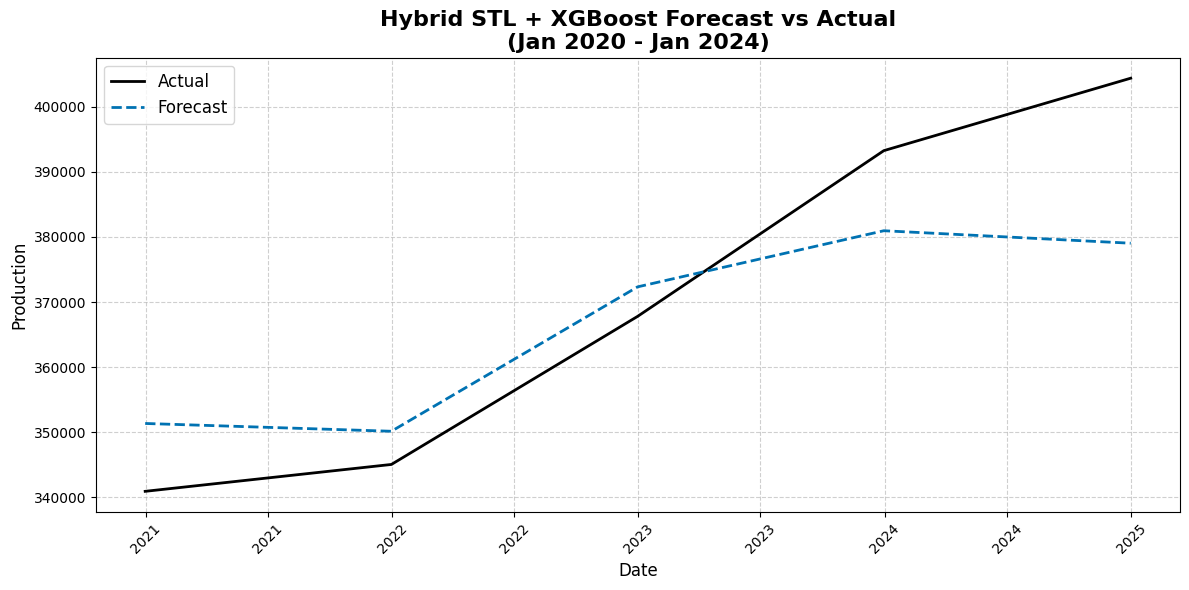

Forecast vs actual plot displayed.

Generating forecast table for model: Hybrid STL + XGBoost
Number of forecasted periods: 60
Forecast table generated successfully.
        Date   Forecast  Lower 90% CI  Upper 90% CI  Lower 95% CI  \
0 2020-01-01  355504.82     331410.84     379598.80     326797.09   
1 2020-02-01  388379.71     362057.66     414701.75     357017.27   
2 2020-03-01  371731.02     346537.33     396924.72     341713.00   
3 2020-04-01  382174.21     356272.73     408075.68     351312.88   
4 2020-05-01  316745.73     295278.60     338212.85     291167.88   

   Upper 95% CI  
0     384212.54  
1     419742.15  
2     401749.05  
3     413035.54  
4     342323.58  
Full-Year Forecast Summary (with 90% & 95% CI):


,Year,Forecast,Lower 90% CI,Upper 90% CI,Lower 95% CI,Upper 95% CI
0,2020,351323.35,327512.76,375133.94,322953.29,379693.41
1,2021,350125.74,326396.32,373855.16,321852.38,378399.09
2,2022,372327.51,347093.39,397561.64,342261.32,402393.70
3,2023,380957.58,355138.56,406776.60,350194.49,411720.67
4,2024,379037.59,353348.70,404726.49,348429.55,409645.64


In [381]:
# Determine forecast start date based on the test or actual data
forecast_start_date = pd.to_datetime('2020-01-01')  # Change this as per your actual forecast start
forecast_end_date = forecast_start_date + pd.DateOffset(months=len(best_forecast) - 1)

# Create date index matching forecast length
dates = pd.date_range(start=forecast_start_date, periods=len(best_forecast), freq='MS')

# Build forecast & actual series with date index
forecast_series = pd.Series(best_forecast, index=dates)
actual_series = pd.Series(best_actual, index=dates)

# Resample to yearly averages
forecast_yearly = forecast_series.resample('YS').mean()
actual_yearly = actual_series.resample('YS').mean()

# Plot yearly forecast vs actuals
plot_best_model_forecast(
    best_model=best_model,
    actual=actual_yearly,
    forecast=forecast_yearly,
    start_date=str(actual_yearly.index[0].date()),
    end_date=str(actual_yearly.index[-1].date()),
    freq='YS'
)

# --- Regenerate forecast_df for full range if needed ---
forecast_df = generate_forecast_table(
    best_model=best_model,
    forecast=best_forecast,
    metrics=best_metrics,
    start_date=str(forecast_start_date)
)

# Prepare yearly confidence intervals from full forecast_df
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
forecast_df['Year'] = forecast_df['Date'].dt.year

# Aggregate by year (mean forecast & CI bounds)
forecast_yearly = forecast_df.groupby('Year').agg({
    'Forecast': 'mean',
    'Lower 90% CI': 'mean',
    'Upper 90% CI': 'mean',
    'Lower 95% CI': 'mean',
    'Upper 95% CI': 'mean'
}).reset_index()

# Round for cleaner display
forecast_yearly = forecast_yearly.round(2)

# Display the updated table
print("Full-Year Forecast Summary (with 90% & 95% CI):")
display(forecast_yearly)

In [382]:
# Save the Pkl file
# Step 1: Load the raw data
df_raw = pd.read_csv("oil_production.csv")

# Step 2: Take forecast start date input from the user
split_input = input("Enter forecast start date (YYYY-MM-DD): ")

try:
    forecast_start = pd.to_datetime(split_input)
except ValueError:
    raise ValueError("Invalid date format. Please enter date as YYYY-MM-DD.")

# Step 3: Preprocess the data
df = preprocess_oil_data(df_raw)

# Step 4: Run Hybrid STL + XGBoost forecast
# Calculate forecast horizon based on months from split to end
forecast_horizon = len(df[df.index >= forecast_start])

print(f"\nForecasting {forecast_horizon} months starting from {forecast_start.date()}...")

hybrid_pred, hybrid_actual, hybrid_metrics, xgb_model_object = hybrid_stl_xgboost(
    df,
    forecast_horizon=forecast_horizon
)

# Step 5: Save the model as a .pkl file
filename = f"best_longterm_model_hybrid_xgb.pkl"
joblib.dump(xgb_model_object, filename)
print(f"\n Hybrid STL + XGBoost model saved as '{filename}'")

Enter forecast start date (YYYY-MM-DD): 2020-01-01
Starting data preprocessing...
Date column created from Year and Month_part.
Filtered to Date and Production columns.
Date column set as index with monthly frequency.
Data preprocessing completed.

Forecasting 61 months starting from 2020-01-01...
Starting STL decomposition...
Seasonal component extracted and residuals computed.
Creating time series features...
Added 'month' and 'year' features.
Added lag feature: lag_1
Added lag feature: lag_2
Added lag feature: lag_3
Added lag feature: lag_6
Added lag feature: lag_12
Final feature set created with shape: (169, 8)

Lag-based features created from residuals.
Train size: 108, Test size: 61
Training XGBoost on residuals...
XGBoost model trained.
Final forecast reconstructed by adding seasonality.
Evaluating forecast...
Mean of actual values: 370060.02
Evaluation Results: {'RMSE (%)': 5.14, 'MAE (%)': 4.05, 'MAPE (%)': 4.09}
Forecast evaluation metrics: {'RMSE (%)': 5.14, 'MAE (%)': 4.05,

# Part 3: Model Tracking and Management with Weights & Biases

This phase involved integrating Weights & Biases (W&B) to track, version, and store the best forecasting models selected from the short-term and long-term forecasting pipelines.


## 1. Objective

The goal was to ensure reproducibility, visibility, and accessibility of the selected models. By logging the best models to W&B, the forecasting process is now aligned with modern MLOps best practices.


## 2. Best Model Selection

From the evaluation pipelines in Part 2, the following models were identified as best performing:

- **Short-Term Forecasting**: Exponential Smoothing (ETS)
- **Long-Term Forecasting**: Hybrid STL + XGBoost

These models were chosen based on their performance metrics (RMSE, MAE, MAPE) and a weighted scoring system.


## 3. Model Serialization

Already saved pkl files were were reused during W&B artifact logging to avoid redundant retraining or re-exporting.


## 4. W&B Logging Strategy

Each best model was logged as a separate run on W&B with the following structure:

- **Run Name**: Reflects the scope (`short_term` or `long_term`) and model type.
- **Model Metrics**: Evaluation metrics were cleaned and logged as key-value pairs.
- **Model Artifacts**: Serialized `.pkl` files were logged as model artifacts for version control and reproducibility.

This approach allowed for easy retrieval, comparison, and visualization via the W&B dashboard.


## 5. Handling Environment Issues

Since the work was conducted in a notebook environment, compatibility issues related to `asyncio` and `uvloop` were addressed by:

- Wrapping `wandb.finish()` in a try-except block
- Ensuring artifact logging occurred only after model files were confirmed to exist

This ensured stable integration without interrupting the workflow.

## 6. Outcome

The best short-term and long-term models are now:

- Logged and versioned in the W&B dashboard
- Associated with their evaluation metrics
- Available for direct download or registry promotion
- Ready for downstream deployment or dashboard integration

In [383]:
pip install wandb

In [384]:
!wandb login

wandb: Currently logged in as: battula_pragati_ampba2025s (battula_pragati_ampba2025s-indian-school-of-business) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [387]:
import wandb
import joblib
import os

# --- Setup W&B project ---
wandb_project = "oil-forecasting"
wandb_entity = None

# -------- SHORT-TERM ETS MODEL --------

# Initialize W&B run
run_ets = wandb.init(
    project=wandb_project,
    name="short_term_ETS",
    config={"model_type": "exponential_smoothing_forecast"},
    entity=wandb_entity
)

# Clean and log metrics
clean_metrics_shortterm = {
    k.replace(" (%)", "").replace("%", "").strip(): v
    for k, v in best_metrics_shortterm.items()
}
wandb.log(clean_metrics_shortterm)

# Log ETS model as artifact
ets_artifact = wandb.Artifact("short_term_ets_model", type="model")
ets_artifact.add_file("best_shortterm_model_ets.pkl")
run_ets.log_artifact(ets_artifact)

run_ets.finish()

# -------- LONG-TERM HYBRID STL + XGBOOST MODEL --------

# Initialize W&B run
run_xgb = wandb.init(
    project=wandb_project,
    name="long_term_HybridSTL_XGB",
    config={"model_type": "hybrid_stl_xgboost"},
    entity=wandb_entity
)

# Clean and log metrics
clean_metrics_longterm = {
    k.replace(" (%)", "").replace("%", "").strip(): v
    for k, v in hybrid_metrics.items()
}
wandb.log(clean_metrics_longterm)

# Log XGBoost model as artifact
xgb_artifact = wandb.Artifact("longterm_model_hybrid_xgb", type="model")
xgb_artifact.add_file("best_longterm_model_hybrid_xgb.pkl")
run_xgb.log_artifact(xgb_artifact)

run_xgb.finish()

MAE,▁
MAPE,▁
RMSE,▁
MAE,1.42
MAPE,1.43
RMSE,1.89


MAE,▁
MAPE,▁
RMSE,▁
MAE,4.05
MAPE,4.09
RMSE,5.14


# Part 4: Drift Monitoring

This phase introduces drift detection mechanisms to monitor the health and reliability of the deployed forecasting models over time. The focus is on identifying both data and concept drift using actual vs forecast comparisons and feature distribution shifts.

## 1. Objective

The objective was to detect and track:

- **Concept Drift**: Changes in the relationship between inputs and the target (e.g., forecast errors increasing over time).
- **Data Drift**: Changes in the distribution of input features used by the forecasting models.

These indicators help ensure that model performance remains stable in production and that retraining is initiated when necessary.

## 2. Concept Drift Detection

Rolling error metrics were computed for both short-term and long-term models:

- **Rolling RMSE**: Measures volatility in forecast error magnitudes.
- **Rolling MAPE**: Tracks shifts in relative forecast accuracy.

A 12-month rolling window was used to smooth short-term variations and highlight structural changes.

Visualizations of these rolling metrics were logged to Weights & Biases (W&B) for real-time monitoring.


## 3. Data Drift Detection (Long-Term Model Only)

For the long-term model (Hybrid STL + XGBoost), data drift was assessed using:

- **Kolmogorov–Smirnov (KS) Test**: Quantifies the difference between the distributions of training and recent input features.
- **Drift Flags**: Features with a p-value less than 0.05 were flagged as exhibiting data drift.

Drift results were tabulated and logged to W&B, including KS statistics, p-values, and binary drift indicators.


## 4. Weights & Biases Integration

A dedicated run was initiated for drift monitoring, and the following were logged:

- Scalar metrics: Latest and maximum RMSE/MAPE values
- Plots: Rolling error metrics visualized over time
- Tables: Feature-wise data drift summary for long-term models
- Flags: Binary indicators for features exhibiting significant drift

All artifacts were versioned and timestamped in the W&B dashboard, enabling historical analysis and alerts for operational monitoring.


## 5. Outcome

The drift monitoring setup now provides:

- Continuous visibility into model reliability post-deployment
- Early warnings for potential degradation
- A foundation for retraining triggers and lifecycle automation

This completes the core MLOps layer for the forecasting pipeline, ensuring that model performance remains observable and actionable over time.

In [395]:
def detect_concept_drift(actual_series, forecast_series, window=12):
    """Compute rolling RMSE and MAPE to detect concept drift."""
    eps = 1e-8  # prevent divide-by-zero

    rolling_rmse = actual_series.rolling(window, min_periods=1).apply(
        lambda x: mean_squared_error(x, forecast_series.loc[x.index]) ** 0.5, raw=False
    )

    rolling_mape = actual_series.rolling(window, min_periods=1).apply(
        lambda x: np.mean(np.abs((x - forecast_series.loc[x.index]) / (x + eps))) * 100, raw=False
    )

    # Plot drift
    plt.figure(figsize=(12, 5))
    plt.plot(rolling_rmse, label='Rolling RMSE')
    plt.plot(rolling_mape, label='Rolling MAPE (%)')
    plt.title('Concept Drift: Rolling Forecast Error')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rolling_rmse, rolling_mape

Short-Term Concept Drift (ETS):


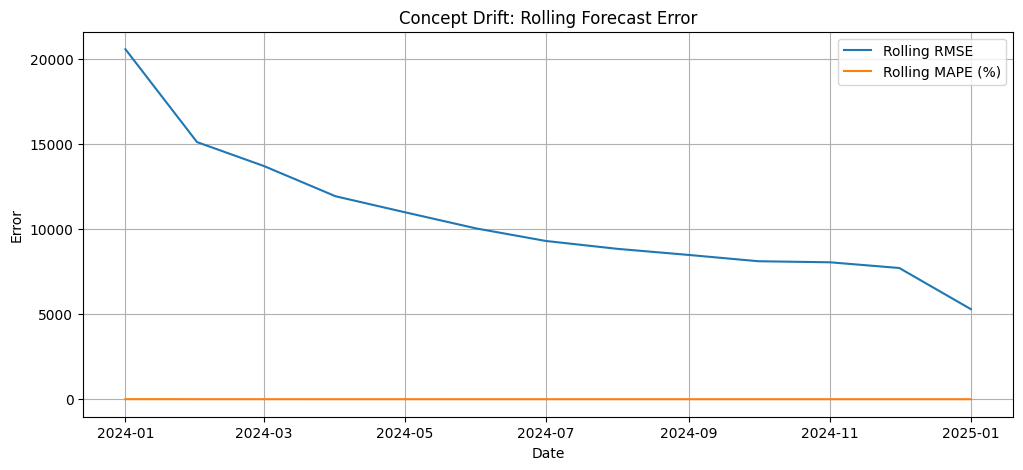

(Date
 2024-01-01    20546.951178
 2024-02-01    15095.016080
 2024-03-01    13687.408002
 2024-04-01    11913.354245
 2024-05-01    10975.923142
 2024-06-01    10022.830533
 2024-07-01     9291.055240
 2024-08-01     8828.284231
 2024-09-01     8469.431715
 2024-10-01     8101.212343
 2024-11-01     8038.982078
 2024-12-01     7704.393637
 2025-01-01     5287.579776
 Freq: MS, dtype: float64,
 Date
 2024-01-01    5.279807
 2024-02-01    3.402027
 2024-03-01    3.109812
 2024-04-01    2.482222
 2024-05-01    2.273425
 2024-06-01    1.920670
 2024-07-01    1.689401
 2024-08-01    1.610587
 2024-09-01    1.563609
 2024-10-01    1.485755
 2024-11-01    1.518358
 2024-12-01    1.415597
 2025-01-01    1.113372
 Freq: MS, dtype: float64)

In [396]:
actual_ets = pd.Series(test['Production'].values, index=test.index)
forecast_ets = pd.Series(ets_vals, index=test.index)

print("Short-Term Concept Drift (ETS):")
detect_concept_drift(actual_ets, forecast_ets)

Long-Term Concept Drift (Hybrid STL + XGBoost):


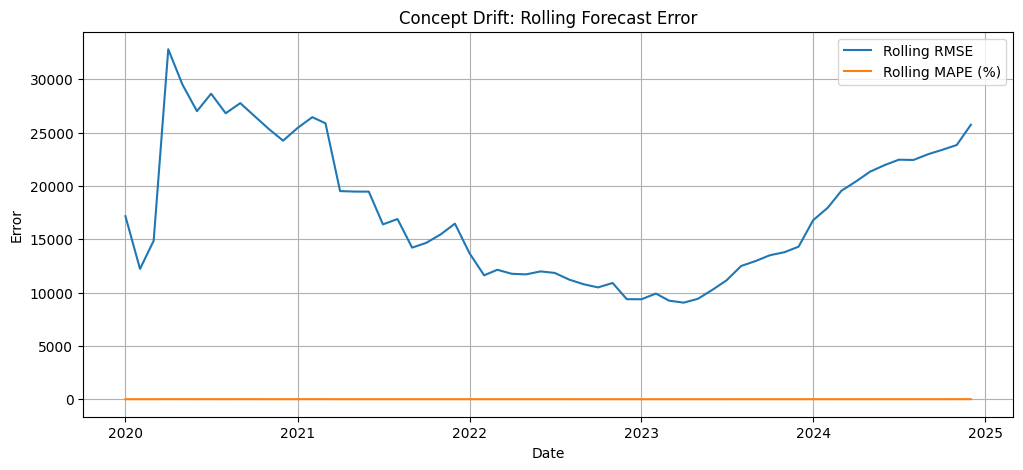

(2020-01-01    17158.023321
 2020-02-01    12218.271235
 2020-03-01    14858.181837
 2020-04-01    32811.428142
 2020-05-01    29508.032312
 2020-06-01    27004.597198
 2020-07-01    28642.313647
 2020-08-01    26807.359206
 2020-09-01    27759.303906
 2020-10-01    26552.578872
 2020-11-01    25317.450156
 2020-12-01    24240.443149
 2021-01-01    25440.298356
 2021-02-01    26441.085077
 2021-03-01    25868.363383
 2021-04-01    19512.535403
 2021-05-01    19468.184042
 2021-06-01    19461.126656
 2021-07-01    16393.951883
 2021-08-01    16891.772736
 2021-09-01    14212.298041
 2021-10-01    14658.469546
 2021-11-01    15463.657657
 2021-12-01    16460.146948
 2022-01-01    13682.018741
 2022-02-01    11616.522459
 2022-03-01    12136.999234
 2022-04-01    11758.422682
 2022-05-01    11704.510364
 2022-06-01    11984.012980
 2022-07-01    11840.381752
 2022-08-01    11208.611810
 2022-09-01    10772.348755
 2022-10-01    10484.294443
 2022-11-01    10897.976472
 2022-12-01     9380

In [397]:
# Align forecast and actuals with date index
dates = pd.date_range(start='2020-01-01', periods=len(best_forecast), freq='MS')
actual_xgb = pd.Series(best_actual, index=dates)
forecast_xgb = pd.Series(best_forecast, index=dates)

print("Long-Term Concept Drift (Hybrid STL + XGBoost):")
detect_concept_drift(actual_xgb, forecast_xgb)

In [398]:
from scipy.stats import ks_2samp

def detect_data_drift(train_df, recent_df, feature_cols):
    """Run KS test for feature-wise data drift."""
    drift_results = {}
    for col in feature_cols:
        stat, p_value = ks_2samp(train_df[col], recent_df[col])
        drift_results[col] = {
            "KS_stat": round(stat, 3),
            "p_value": round(p_value, 5),
            "drift_detected": p_value < 0.05
        }
    return pd.DataFrame(drift_results).T

In [399]:
# Use the feature-engineered DataFrame for XGBoost
df_feat = create_features(df)  # lag_1, lag_2, ..., month, year

# Assume training = all except last 60 months
train_xgb = df_feat.iloc[:-60]
recent_xgb = df_feat.iloc[-60:]

feature_cols = [col for col in df_feat.columns if col != 'Production']

print("Long-Term Data Drift (Feature Shift):")
drift_summary = detect_data_drift(train_xgb, recent_xgb, feature_cols)
display(drift_summary)

Creating time series features...
Added 'month' and 'year' features.
Added lag feature: lag_1
Added lag feature: lag_2
Added lag feature: lag_3
Added lag feature: lag_6
Added lag feature: lag_12
Final feature set created with shape: (169, 8)

Long-Term Data Drift (Feature Shift):


,KS_stat,p_value,drift_detected
month,0.008,1.0,False
year,0.991,0.0,True
lag_1,0.768,0.0,True
lag_2,0.777,0.0,True
lag_3,0.787,0.0,True
lag_6,0.814,0.0,True
lag_12,0.869,0.0,True


In [400]:
import wandb

run = wandb.init(
    project="oil-forecasting",
    name="drift_monitoring",
    config={"task": "drift_detection"},
    entity=None  # add if using a team account
)

In [401]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# -------- Concept Drift Function -------- #
def detect_concept_drift(actual_series, forecast_series, window=12):
    rolling_rmse = actual_series.rolling(window).apply(
        lambda x: mean_squared_error(x, forecast_series.loc[x.index]) ** 0.5, raw=False
    )
    rolling_mape = actual_series.rolling(window).apply(
        lambda x: np.mean(np.abs((x - forecast_series.loc[x.index]) / x)) * 100, raw=False
    )
    return rolling_rmse, rolling_mape

In [402]:
# Create date-aligned series (use your own forecast values if different)
actual_short = pd.Series(test['Production'].values, index=test.index)
forecast_short = pd.Series(ets_vals, index=test.index)

# For long-term (use your best_forecast/best_actual from previous run)
longterm_dates = pd.date_range(start='2024-01-01', periods=len(best_forecast), freq='MS')
actual_long = pd.Series(best_actual, index=longterm_dates)
forecast_long = pd.Series(best_forecast, index=longterm_dates)

# Compute rolling errors
rolling_rmse_short, rolling_mape_short = detect_concept_drift(actual_short, forecast_short)
rolling_rmse_long, rolling_mape_long = detect_concept_drift(actual_long, forecast_long)

In [403]:
from scipy.stats import ks_2samp

def detect_data_drift(train_df, recent_df, feature_cols):
    drift_results = {}
    for col in feature_cols:
        stat, p_value = ks_2samp(train_df[col], recent_df[col])
        drift_results[col] = {
            "KS_stat": round(stat, 3),
            "p_value": round(p_value, 5),
            "drift_detected": p_value < 0.05
        }
    return pd.DataFrame(drift_results).T

# Build recent and training data for long-term features
df_feat = create_features(df)
train_xgb = df_feat.iloc[:-60]
recent_xgb = df_feat.iloc[-60:]
feature_cols = [col for col in df_feat.columns if col != 'Production']

drift_summary = detect_data_drift(train_xgb, recent_xgb, feature_cols)

Creating time series features...
Added 'month' and 'year' features.
Added lag feature: lag_1
Added lag feature: lag_2
Added lag feature: lag_3
Added lag feature: lag_6
Added lag feature: lag_12
Final feature set created with shape: (169, 8)



In [404]:
run = wandb.init(
    project="oil-forecasting",
    name="drift_monitoring",
    config={"task": "drift_detection"}
)

# Log concept drift metrics
wandb.log({
    "shortterm_rmse_latest": rolling_rmse_short[-1],
    "shortterm_mape_latest": rolling_mape_short[-1],
    "longterm_rmse_latest": rolling_rmse_long[-1],
    "longterm_mape_latest": rolling_mape_long[-1]
})

# Log rolling error plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rolling_rmse_short, label='Short-Term RMSE')
ax.plot(rolling_mape_short, label='Short-Term MAPE (%)')
ax.plot(rolling_rmse_long, label='Long-Term RMSE', linestyle='--')
ax.plot(rolling_mape_long, label='Long-Term MAPE (%)', linestyle='--')
ax.set_title('Rolling Forecast Error (Concept Drift)')
ax.set_xlabel('Date')
ax.set_ylabel('Error')
ax.legend()
wandb.log({"concept_drift_plot": wandb.Image(fig)})
plt.close()

In [407]:
# Start W&B run and store it
run = wandb.init(
    project="oil-forecasting",
    name="drift-analysis",
    entity=None,  # or None for personal
    job_type="drift-monitoring"
)

# Flatten drift results for scalar logging
drift_flags = {
    f"drift_{col}": int(row['drift_detected']) for col, row in drift_summary.iterrows()
}
ks_stats = {
    f"ks_stat_{col}": float(row['KS_stat']) for col, row in drift_summary.iterrows()
}
p_values = {
    f"pval_{col}": float(row['p_value']) for col, row in drift_summary.iterrows()
}

# Log all scalar metrics
wandb.log({**drift_flags, **ks_stats, **p_values}, commit=False)

# Log full drift summary table
wandb.log({
    "data_drift_table": wandb.Table(dataframe=drift_summary.reset_index())
})

# Finish run safely
try:
    run.finish()
except Exception as e:
    print(" W&B run could not finish cleanly:", str(e))

wandb: ERROR Problem finishing run


 W&B run could not finish cleanly: Can't patch loop of type <class 'uvloop.Loop'>


# Part 5  Model Retraining

## Concept Drift Detection
We monitored short-term and long-term forecast performance using rolling RMSE and MAPE. Significant deviations triggered retraining of the models.

## Retraining Workflow
- **Short-Term Model**: Exponential Smoothing (ETS) was retrained using the latest time series data.
- **Long-Term Model**: A Hybrid STL + XGBoost model was retrained using updated lag-based features.

## Model Versioning
- Retrained models were logged to W&B as versioned artifacts.
- This ensures reproducibility, auditability, and seamless deployment into the forecasting API.

In [409]:
import pandas as pd
import joblib
import numpy as np
import wandb
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Start new retraining W&B run
run = wandb.init(
    project="oil-forecasting",
    name="retrain-after-drift",
    job_type="retraining",
    entity=None # optional
)

# -------- Prepare data --------
df = df.sort_index()
train = df.copy()  # Retrain on full data

# -------- 1. Retrain ETS --------
ets_model = ExponentialSmoothing(train['Production'], trend='add', seasonal='add', seasonal_periods=12).fit()
joblib.dump(ets_model, "retrained_ets_model.pkl")

# Log to W&B
ets_artifact = wandb.Artifact("retrained_ets_model", type="model")
ets_artifact.add_file("retrained_ets_model.pkl")
run.log_artifact(ets_artifact)

# -------- 2. Retrain XGBoost --------
def create_lag_features(df, lags=[1, 2, 3, 6, 12]):
    df_lag = df.copy()
    for lag in lags:
        df_lag[f'lag_{lag}'] = df_lag['Production'].shift(lag)
    df_lag['month'] = df_lag.index.month
    df_lag['year'] = df_lag.index.year
    return df_lag.dropna()

df_lagged = create_lag_features(df)
X = df_lagged[['month', 'year', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']]
y = df_lagged['Production']

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05)
xgb_model.fit(X, y)
joblib.dump(xgb_model, "retrained_xgb_model.pkl")

# Log to W&B
xgb_artifact = wandb.Artifact("retrained_xgb_model", type="model")
xgb_artifact.add_file("retrained_xgb_model.pkl")
run.log_artifact(xgb_artifact)

# Finish run
wandb.finish()